In [2]:
%pip install ipykernel
%pip install yfinance
%pip install pymoo
%pip install pandas numpy matplotlib seaborn
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install talib-binary
%pip install TA-Lib

ERROR: Could not find a version that satisfies the requirement talib-binary (from versions: none)
ERROR: No matching distribution found for talib-binary


In [3]:
import warnings
import yfinance as yf
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# --- Setup ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [4]:
import yfinance as yf
import pandas as pd

# Define the tickers for the selected assets, including SPY
# NOTE: SPY is included in the download for BENCHMARK comparison only
#       It will be EXCLUDED from portfolio optimization and Bi-LSTM training
#       SPY is only used to compare performance against the optimized portfolio

#tickers = ['QQQ', 'SCHD', 'GLD', 'USDU', 'IEF', 'VNQ', 'SPY'] # Replaced BTC-USD with FXE (Invesco CurrencyShares Euro Trust)
#tickers = ['QQQ', 'XLE', 'XLP', 'VEA', 'GLD', 'FXE', 'SCHH', 'SCHD', 'IEF', 'SPY']
# Porfolio selection based on applying diverisification principles
tickers = ['AAPL', 'GOOG', 'MSFT', 'NVDA',
           'AMZN', 'AMD', 'INTC', 'META',
           'COST', 'PG', 'KO', 'PEP', 'WMT',
           'CME', 'AVGO', 'PFE', 'ABBV', 'HD',
           'XOM', 'VDE',
           'SCHD', 'VYM',
           'VWO', 'VEA',
           'GLD', 'SLV',
           'FXY', 'FDIVX',
           'TLT', 'SPLB',
           'SPY']  # <-- SPY is BENCHMARK ONLY (excluded from portfolio)
# Download historical data for the last 25 years
data = yf.download(tickers, period='25y') # Changed period to 10y

# We'll focus on the 'Close' price since 'Adj Close' is not directly available
# Use dropna(how='all') to only remove rows where ALL tickers are NaN
# This preserves SPY and other tickers even if some have missing data
close_data = data['Close'].dropna(how='all')

# Forward fill any remaining NaN values to handle missing data points
close_data = close_data.fillna(method='ffill').fillna(method='bfill')

# Ensure close_data index is timezone-naive for consistent alignment
if close_data.index.tz is not None:
    close_data.index = close_data.index.tz_localize(None)

display(close_data.tail())
print(f"\n✓ Close data shape: {close_data.shape}")
print(f"✓ Tickers included: {list(close_data.columns)}")
print(f"✓ SPY included: {'SPY' in close_data.columns}")

[*********************100%***********************]  31 of 31 completed


Ticker,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,GOOG,HD,INTC,KO,META,MSFT,NVDA,PEP,PFE,PG,SCHD,SLV,SPLB,SPY,TLT,VDE,VEA,VWO,VYM,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-17,267.459991,234.000000,240.520004,232.869995,342.649994,279.130005,912.590027,51.700001,59.240002,371.649994,285.600006,358.029999,34.709999,70.680000,602.010010,506.541931,186.600006,147.830002,25.080000,145.820007,27.000000,45.470001,22.709999,665.669983,89.089996,127.050003,60.529999,54.220001,139.539993,102.949997,117.680000
2025-11-18,267.440002,233.869995,230.289993,222.550003,340.500000,279.279999,895.080017,50.959999,59.150002,374.350006,284.959991,336.480011,34.330002,71.220001,597.690002,492.867554,181.360001,148.770004,25.450001,146.990005,27.160000,46.099998,22.719999,660.080017,89.059998,128.149994,59.910000,54.040001,139.509995,101.389999,119.029999
2025-11-19,268.559998,232.910004,223.550003,222.690002,354.420013,272.489990,890.599976,50.709999,58.610001,374.959991,292.989990,334.500000,35.110001,71.110001,590.320007,486.209991,186.520004,147.110001,24.879999,146.990005,26.930000,46.450001,22.709999,662.630005,88.879997,126.629997,59.709999,53.919998,139.690002,100.610001,117.349998
2025-11-20,266.250000,229.449997,206.020004,217.139999,346.820007,275.220001,893.289978,49.910000,58.330002,374.850006,289.980011,332.380005,33.619999,71.209999,589.150024,478.429993,180.639999,146.100006,24.400000,148.190002,26.620001,45.779999,22.740000,652.530029,89.230003,125.059998,58.900002,53.279999,138.429993,107.110001,117.019997
2025-11-21,271.489990,236.279999,203.779999,220.690002,340.200012,273.089996,899.010010,50.580002,58.779999,374.269989,299.649994,343.320007,34.500000,72.949997,594.250000,472.119995,178.880005,146.330002,25.040001,150.919998,27.100000,45.299999,22.830000,659.030029,89.500000,125.790001,59.770000,53.070000,140.100006,105.320000,117.080002



✓ Close data shape: (6287, 31)
✓ Tickers included: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'SPY', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']
✓ SPY included: True


In [5]:
# Calculate daily returns
daily_returns = close_data.pct_change().dropna()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1

display(cumulative_returns.tail())
print(f"\n✓ Cumulative returns shape: {cumulative_returns.shape}")
print(f"✓ SPY in cumulative_returns: {'SPY' in cumulative_returns.columns}")

Ticker,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,GOOG,HD,INTC,KO,META,MSFT,NVDA,PEP,PFE,PG,SCHD,SLV,SPLB,SPY,TLT,VDE,VEA,VWO,VYM,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-17,963.108242,10.197001,11.255796,183.909181,299.055471,65.040881,38.593978,7.535915,-0.283589,7.374267,114.061682,15.600683,0.481607,3.829933,14.844133,23.299869,897.271550,5.284818,0.581816,6.528636,4.036490,2.292065,1.418165,6.914578,1.412905,3.200365,1.193302,2.711025,3.948800,9.493167,4.547148
2025-11-18,963.036188,10.190780,10.734522,175.714646,297.172741,65.076369,37.834282,7.413737,-0.284678,7.435106,113.803835,14.601481,0.465387,3.866834,14.730436,22.643881,872.046750,5.324781,0.605152,6.589043,4.066336,2.337677,1.419230,6.848115,1.412093,3.236732,1.170837,2.698705,3.947736,9.334164,4.610784
2025-11-19,967.073415,10.144844,10.391083,175.825812,309.362370,63.469884,37.639909,7.372461,-0.291208,7.448850,117.038937,14.509674,0.498682,3.859317,14.536467,22.324504,896.886430,5.254208,0.569202,6.589043,4.023432,2.363018,1.418165,6.878434,1.407218,3.186480,1.163589,2.690492,3.954120,9.254663,4.531593
2025-11-20,958.746608,9.979282,9.497835,171.418861,302.707114,64.115792,37.756618,7.240378,-0.294594,7.446372,115.826285,14.411377,0.435080,3.866150,14.505674,21.951281,868.580744,5.211269,0.538928,6.650998,3.965606,2.314509,1.421360,6.758349,1.416697,3.134574,1.134239,2.646688,3.909434,9.917174,4.516037
2025-11-21,977.635107,10.306100,9.383694,174.237722,296.910044,63.611843,38.004790,7.350998,-0.289152,7.433303,119.722099,14.918629,0.472643,3.985053,14.639899,21.648578,860.108328,5.221047,0.579293,6.791947,4.055144,2.279757,1.430943,6.835631,1.424010,3.158709,1.165764,2.632315,3.968661,9.734729,4.518866



✓ Cumulative returns shape: (6286, 31)
✓ SPY in cumulative_returns: True


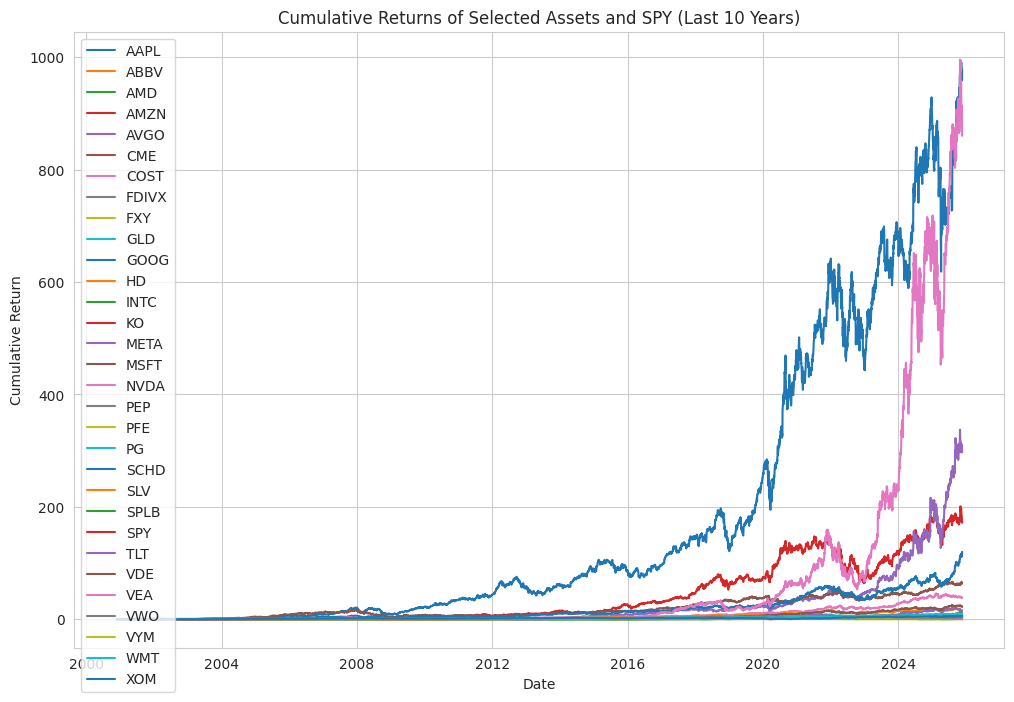

In [6]:
import matplotlib.pyplot as plt

# Plot cumulative returns
plt.figure(figsize=(12, 8))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('Cumulative Returns of Selected Assets and SPY (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import yfinance as yf
import pandas as pd

# Exclude SPY from the list of portfolio tickers
portfolio_tickers = list(filter(lambda item: item != 'SPY', tickers))

# Initialize dividend_data with the full date range of close_data and all portfolio tickers
# Fill with 0.0 initially, as dividends are sparse.
dividend_data = pd.DataFrame(0.0, index=close_data.index, columns=portfolio_tickers)

for ticker in portfolio_tickers:
    try:
        dividends_series = yf.Ticker(ticker).dividends
        if not dividends_series.empty:
            # Ensure dividend index is timezone-naive for consistent alignment
            if dividends_series.index.tz is not None:
                dividends_series.index = dividends_series.index.tz_localize(None)

            # Reindex the dividend series to the full close_data index and fill NaNs with 0
            # Then assign it to the corresponding column in the pre-initialized dividend_data DataFrame
            dividend_data[ticker] = dividends_series.reindex(close_data.index, fill_value=0.0)

    except Exception as e:
        print(f"Could not retrieve dividend data for {ticker}: {e}")

# The dividend_data DataFrame is already filled with 0.0 for non-dividend days during reindexing,
# so a final fillna(0) might be redundant but doesn't hurt.
dividend_data = dividend_data.fillna(0)
display(dividend_data.tail())

,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-17,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-18,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-19,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-20,0.0,0.0,0.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-21,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# To calculate the total dividends paid by an equal-weighted portfolio,
# we can sum the dividends paid by each asset on each date and divide by the number of assets.
# However, dividend payments are not daily. We'll resample to a more appropriate frequency, like monthly or quarterly,
# and calculate the sum of dividends paid within each period. Let's use a monthly frequency.
monthly_dividends = dividend_data.resample('M').sum()

annualized_dividends = monthly_dividends.resample('Y').sum()
display("Annualized Dividends Paid by Equal Weighted Portfolio (Last 10 Years):")
display(annualized_dividends)

annualized_yield = annualized_dividends / close_data[annualized_dividends.columns]

# Assuming an equal-weighted portfolio, the total dividend received by the portfolio in each month
# is the sum of dividends from each asset divided by the number of assets.
# We need to align this with the dates in our price data.
# For simplicity here, we'll calculate the cumulative sum of dividends based on the dividend payment dates.
# A more precise calculation would involve tracking the portfolio holdings over time.

# Let's calculate the cumulative sum of dividends over time
cumulative_dividends = monthly_dividends.sum(axis=1).cumsum()

display("Cumulative Dividends Paid by Equal Weighted Portfolio (Monthly):")
display(cumulative_dividends.tail())

'Annualized Dividends Paid by Equal Weighted Portfolio (Last 10 Years):'

,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-12-31,0.000000,0.00,0.00,0.000000,0.0,0.0,0.000,0.000,0.000,0.0000,0.085,0.140,0.020000,0.000,0.000,0.000000,0.00,0.040,0.00,0.000,0.000000,0.000,0.0000,0.000,0.0,0.0,0.0,1.360,0.000,0.000000
2001-12-31,0.000000,0.00,0.00,0.000000,0.0,0.0,0.080,0.000,0.000,0.7300,0.540,0.575,0.093332,0.000,0.000,0.417456,0.00,0.220,0.91,0.000,0.000000,0.000,0.0000,0.000,0.0,0.0,0.0,0.010,0.000,0.000000
2002-12-31,0.000000,0.00,0.00,0.000000,0.0,0.0,0.080,0.000,0.000,1.1350,0.400,0.595,0.100000,0.000,0.000,0.493360,0.00,0.210,0.92,0.000,0.000000,0.000,0.0000,0.000,0.0,0.0,0.0,0.130,1.940,0.000000
2003-12-31,0.000000,0.00,0.24,0.000000,0.0,0.0,0.080,0.000,0.000,0.8650,0.440,0.630,0.120000,0.126,0.000,0.569260,0.00,0.260,0.98,0.000,0.000000,0.000,0.0000,0.000,0.0,0.0,0.0,0.300,4.533,0.000000
2004-12-31,0.000000,0.00,3.16,0.000000,0.0,0.0,0.160,0.000,0.300,0.9775,0.500,0.850,0.173332,0.208,0.000,0.645160,0.00,0.325,1.06,0.216,0.000000,0.000,0.0000,0.000,0.0,0.0,0.0,0.210,4.142,0.000000
2005-12-31,0.000000,0.00,0.32,0.000000,0.0,0.0,0.320,0.000,0.445,1.0900,0.560,1.010,0.200000,0.368,0.000,0.721064,0.00,0.400,1.14,0.701,0.000000,0.000,0.5385,0.000,0.0,0.0,0.0,1.010,4.179,0.000000
2006-12-31,0.000000,0.00,0.37,0.000000,0.0,0.0,0.400,0.000,0.505,1.2100,0.620,1.160,0.224000,0.504,0.000,0.910816,0.00,0.675,1.28,0.929,0.000000,0.175,0.6695,0.000,0.0,0.0,0.0,2.870,3.994,0.000000
2007-12-31,0.000000,0.00,0.41,0.000000,0.0,0.0,0.452,0.000,0.565,1.3600,0.680,1.425,0.293332,0.688,0.000,1.100568,0.00,0.900,1.37,0.940,0.000000,1.357,0.9845,1.055,0.0,0.0,0.0,3.040,4.192,0.000000
2008-12-31,0.000000,0.00,0.46,0.000000,0.0,0.0,0.548,0.000,0.625,1.5500,0.760,1.650,0.317332,1.920,0.000,1.214420,0.00,0.900,1.55,1.183,0.000000,1.443,1.1780,0.930,0.0,0.0,0.0,0.312,4.170,0.000000


'Cumulative Dividends Paid by Equal Weighted Portfolio (Monthly):'

,0
Date,
2025-07-31,880.653555
2025-08-31,884.699555
2025-09-30,894.613555
2025-10-31,899.017555
2025-11-30,902.071555


In [9]:
import pandas as pd

# Ensure dividend_data and close_data are available
if 'dividend_data' not in globals() or 'close_data' not in globals():
    raise ValueError("dividend_data or close_data not found. Please ensure these are loaded.")

# Calculate annual dividends paid per ticker
# We'll reindex dividend_data to close_data's index and then resample annually
aligned_daily_dividends = dividend_data.reindex(close_data.index).fillna(0)
annual_dividends_sum = aligned_daily_dividends.resample('YE').sum()

# Get year-end closing prices per ticker
# Find the last available close price for each year
annual_closing_prices = close_data.resample('YE').last()

# Calculate the annualized dividend yield for each year and ticker
# Handle potential division by zero by replacing 0s with NaN before division
annual_dividend_yield_per_ticker = annual_dividends_sum.div(annual_closing_prices.replace(0, pd.NA))

display("Annualized Dividend Yield (Annual Dividends / Year-End Price) per Ticker:")
display(annual_dividend_yield_per_ticker.fillna(0).tail())

# Optional: Display mean annual yield over the period for comparison
#display("\nAverage Annualized Dividend Yield (Mean over years) per Ticker:")
#display(annual_dividend_yield_per_ticker.mean().fillna(0).sort_values(ascending=False))

'Annualized Dividend Yield (Annual Dividends / Year-End Price) per Ticker:'

,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,GOOG,HD,INTC,KO,META,MSFT,NVDA,PEP,PFE,PG,SCHD,SLV,SPLB,SPY,TLT,VDE,VEA,VWO,VYM,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-31,0.004974,0.044535,0.0,0.0,0.024127,0.034968,0.005672,0.122932,0.0,0.0,0.000000,0.017482,0.029143,0.031748,0.000000,0.007068,0.000545,0.027453,0.032446,0.022984,0.031893,0.0,0.036071,0.0,0.017102,0.047070,0.035366,0.029499,0.030865,0.015987,0.065742
2022-12-31,0.007109,0.038952,0.0,0.0,0.031553,0.056270,0.007966,0.015167,0.0,0.0,0.000000,0.025801,0.057287,0.030070,0.000000,0.010845,0.001096,0.027386,0.037144,0.025686,0.037537,0.0,0.052134,0.0,0.029794,0.039869,0.031655,0.044409,0.032562,0.016353,0.035682
2023-12-31,0.004981,0.040982,0.0,0.0,0.017419,0.048647,0.029042,0.045323,0.0,0.0,0.000000,0.025168,0.014924,0.032895,0.000000,0.007530,0.000323,0.030946,0.064820,0.026820,0.037265,0.0,0.050531,0.0,0.036491,0.035273,0.033184,0.036694,0.032686,0.014746,0.039460
2024-12-31,0.003971,0.036110,0.0,0.0,0.009426,0.045427,0.004937,0.039303,0.0,0.0,0.003161,0.023561,0.018703,0.031855,0.003424,0.007361,0.000253,0.036100,0.067906,0.024257,0.037465,0.0,0.054387,0.0,0.044578,0.033085,0.034150,0.032285,0.027923,0.009278,0.037008
2025-12-31,0.003794,0.027764,0.0,0.0,0.005203,0.013732,0.005628,0.000000,0.0,0.0,0.002069,0.020098,0.000000,0.020973,0.002650,0.007202,0.000168,0.028709,0.068690,0.027684,0.028376,0.0,0.043364,0.0,0.035732,0.022911,0.016229,0.008781,0.018230,0.006694,0.034165


In [10]:
import pandas as pd
import numpy as np

# Ensure required dataframes are available
if 'annual_dividend_yield_per_ticker' not in globals():
    raise ValueError("annual_dividend_yield_per_ticker is not defined. Please run the previous cell to calculate it.")
if 'annual_closing_prices' not in globals():
    raise ValueError("annual_closing_prices is not defined. Please run the previous cell to calculate it.")
if 'close_data' not in globals():
    raise ValueError("close_data is not defined. Please ensure historical price data is downloaded.")

# 1. Calculate the total annual dividends in dollar amounts
# We need to ensure indices and columns align for multiplication
# Reindex annual_closing_prices to match annual_dividend_yield_per_ticker index and columns
aligned_annual_closing_prices = annual_closing_prices.reindex_like(annual_dividend_yield_per_ticker)
annual_dividend_dollars_per_ticker = annual_dividend_yield_per_ticker * aligned_annual_closing_prices

# Fill any NaNs that might result from missing data points in either source with 0
annual_dividend_dollars_per_ticker = annual_dividend_dollars_per_ticker.fillna(0)

# 2. Determine the number of trading days for each year
# Group close_data by year and count the number of entries
trading_days_per_year = close_data.groupby(close_data.index.year).size()

# Create a DataFrame to store the new aligned daily dividend data
aligned_daily_dividend_data_new = pd.DataFrame(0.0, index=close_data.index, columns=portfolio_tickers)

# 3. Distribute annual dividends evenly across trading days in each year
for year in annual_dividend_dollars_per_ticker.index.year.unique():
    if year in trading_days_per_year.index:
        num_days = trading_days_per_year[year]
        if num_days > 0:
            # Get the annual dividend dollars for the current year
            annual_dividends_for_year = annual_dividend_dollars_per_ticker.loc[annual_dividend_dollars_per_ticker.index.year == year].iloc[0]

            # Calculate the daily average dividend amount for this year
            daily_avg_dividends_for_year = annual_dividends_for_year / num_days

            # Assign this daily average to all trading days within that year
            year_mask = (aligned_daily_dividend_data_new.index.year == year)
            # Ensure alignment of columns and use .loc for assignment
            aligned_daily_dividend_data_new.loc[year_mask, daily_avg_dividends_for_year.index] = daily_avg_dividends_for_year.values

# Display the head and tail of the newly created DataFrame
display("New Aligned Daily Dividend Data (derived from annual yield/year-end price distributed daily):")
display(aligned_daily_dividend_data_new.tail())

# Update the global aligned_daily_dividend_data variable with the new calculation
aligned_daily_dividend_data = aligned_daily_dividend_data_new

# Update nsga_ii_data with the average annual dividend yield (re-calculating using this new data)
# Recalculate average_dividend_yield from the newly created aligned_daily_dividend_data
cols = list(portfolio_tickers)

# Reindex aligned_daily_dividend_data to close_data's index if not already (should be the case)
div_df_aligned = aligned_daily_dividend_data.reindex(close_data.index).fillna(0)

# Calculate annual dividends sum
annual_div_sum = div_df_aligned.resample('YE').sum()

# Get year-end closing prices per ticker for average yield calculation
annual_close_prices_for_yield = close_data.resample('YE').last()

# Calculate average annual yield based on new data
# Handle potential division by zero
avg_annual_yield = (annual_div_sum.div(annual_close_prices_for_yield.replace(0, np.nan))).mean(axis=0).reindex(cols).fillna(0)


'New Aligned Daily Dividend Data (derived from annual yield/year-end price distributed daily):'

,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB,SPY
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-17,0.004598,0.002768,0.015179,0.000134,0.0,0.0,0.0,0.007031,0.022589,0.018652,0.00683,0.018754,0.003147,0.016741,0.007902,0.007679,0.029286,0.030804,0.017857,0.012866,0.003433,0.011402,0.00208,0.00433,0.0,0.0,0.0,0.0,0.014277,0.00442,0.0
2025-11-18,0.004598,0.002768,0.015179,0.000134,0.0,0.0,0.0,0.007031,0.022589,0.018652,0.00683,0.018754,0.003147,0.016741,0.007902,0.007679,0.029286,0.030804,0.017857,0.012866,0.003433,0.011402,0.00208,0.00433,0.0,0.0,0.0,0.0,0.014277,0.00442,0.0
2025-11-19,0.004598,0.002768,0.015179,0.000134,0.0,0.0,0.0,0.007031,0.022589,0.018652,0.00683,0.018754,0.003147,0.016741,0.007902,0.007679,0.029286,0.030804,0.017857,0.012866,0.003433,0.011402,0.00208,0.00433,0.0,0.0,0.0,0.0,0.014277,0.00442,0.0
2025-11-20,0.004598,0.002768,0.015179,0.000134,0.0,0.0,0.0,0.007031,0.022589,0.018652,0.00683,0.018754,0.003147,0.016741,0.007902,0.007679,0.029286,0.030804,0.017857,0.012866,0.003433,0.011402,0.00208,0.00433,0.0,0.0,0.0,0.0,0.014277,0.00442,0.0
2025-11-21,0.004598,0.002768,0.015179,0.000134,0.0,0.0,0.0,0.007031,0.022589,0.018652,0.00683,0.018754,0.003147,0.016741,0.007902,0.007679,0.029286,0.030804,0.017857,0.012866,0.003433,0.011402,0.00208,0.00433,0.0,0.0,0.0,0.0,0.014277,0.00442,0.0


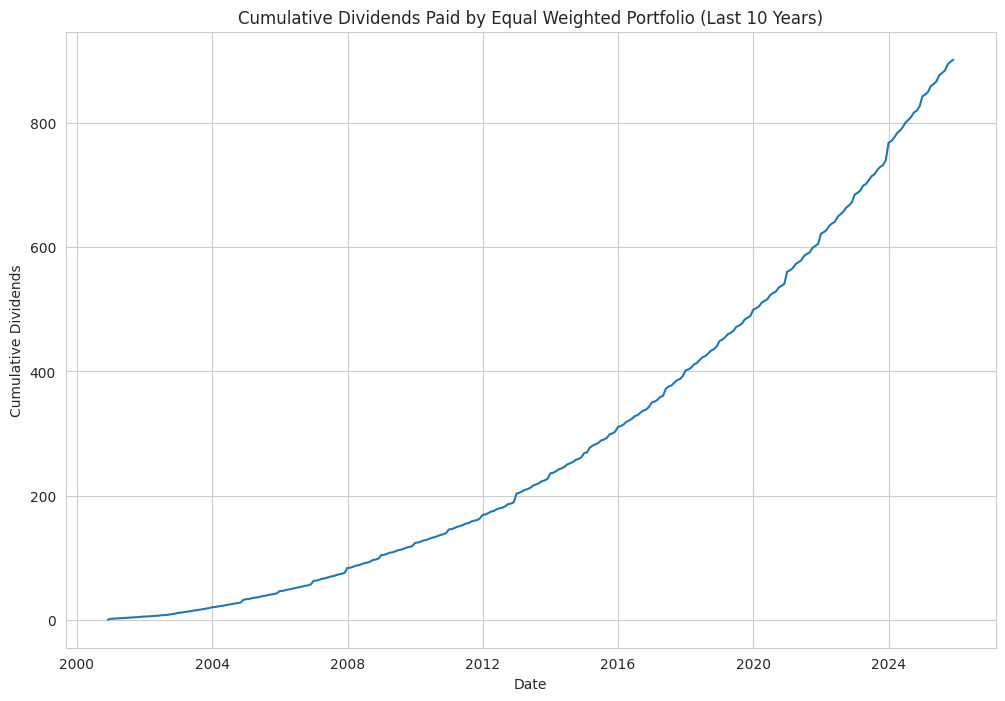

In [11]:
import matplotlib.pyplot as plt

# Plot cumulative dividends paid by the portfolio
plt.figure(figsize=(12, 8))
plt.plot(cumulative_dividends.index, cumulative_dividends)

plt.title('Cumulative Dividends Paid by Equal Weighted Portfolio (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Cumulative Dividends')
plt.grid(True)
plt.show()

In [12]:
# Exclude SPY from the portfolio
portfolio_assets = close_data.drop(columns=['SPY'])

# Calculate daily returns for the portfolio assets
portfolio_daily_returns = portfolio_assets.pct_change().dropna()

# For a simple equal-weighted portfolio, the portfolio daily return is the average of the asset daily returns
portfolio_returns = portfolio_daily_returns.mean(axis=1)

# Calculate cumulative returns of the portfolio
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1

display("Portfolio Cumulative Returns (Equal Weighted):")
display(portfolio_cumulative_returns.tail())

'Portfolio Cumulative Returns (Equal Weighted):'

,0
Date,
2025-11-17,24.743300
2025-11-18,24.564174
2025-11-19,24.514628
2025-11-20,24.270599
2025-11-21,24.464319


In [13]:
import numpy as np

# Calculate annualized volatility (assuming 252 trading days in a year)
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity in this example)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

display(f"Portfolio Annualized Volatility (Equal Weighted): {annualized_volatility:.4f}")
display(f"Portfolio Sharpe Ratio (Equal Weighted): {sharpe_ratio:.4f}")

'Portfolio Annualized Volatility (Equal Weighted): 0.1453'

'Portfolio Sharpe Ratio (Equal Weighted): 0.9663'

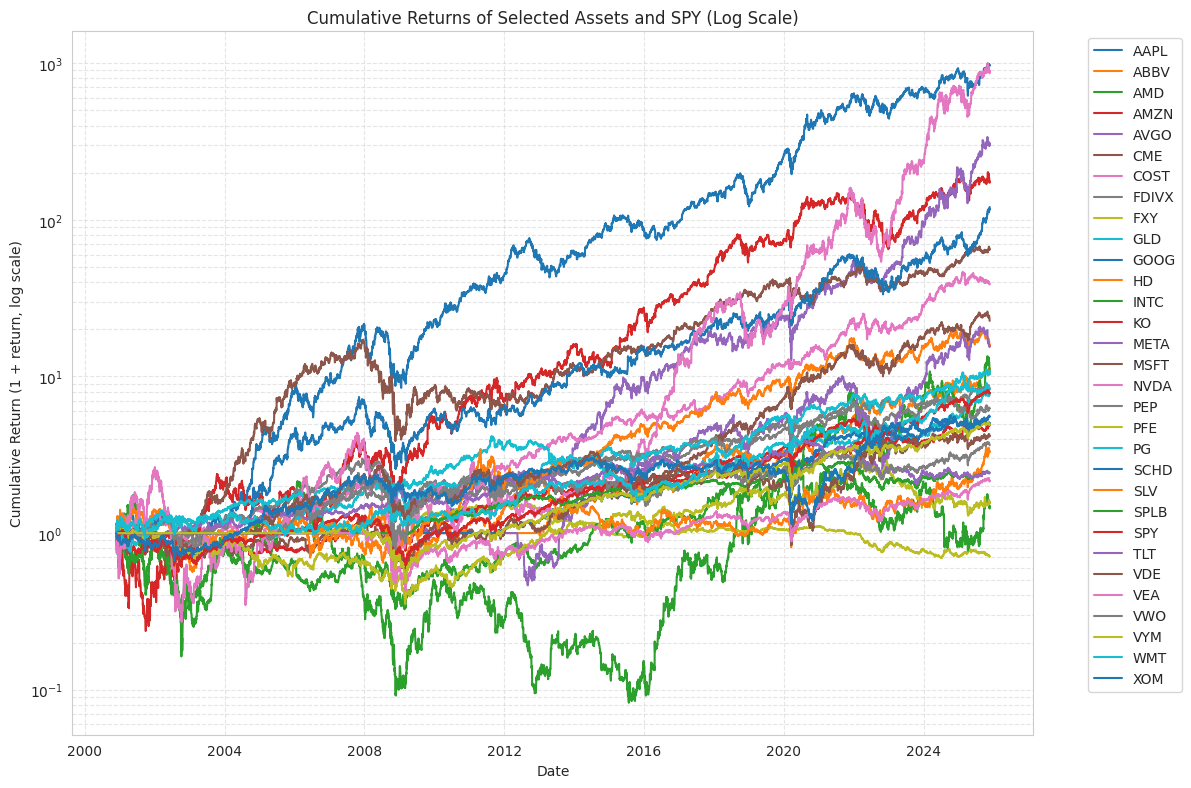

In [14]:
import matplotlib.pyplot as plt

# Plot cumulative returns with log scale
plt.figure(figsize=(12, 8))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker] + 1, label=ticker)  # +1 to avoid log(0)

plt.yscale('log')  # Enable log scale
plt.title('Cumulative Returns of Selected Assets and SPY (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (1 + return, log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import pandas as pd

# Calculate daily returns for SPY
spy_returns = daily_returns['SPY']

# Calculate Annualized Volatility for SPY (assuming 252 trading days in a year)
spy_annualized_volatility = spy_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio for SPY (assuming risk-free rate is 0 for simplicity)
spy_sharpe_ratio = spy_returns.mean() / spy_returns.std() * np.sqrt(252)

# Calculate Value at Risk (VaR) for SPY
# VaR at a certain confidence level (e.g., 95%) represents the maximum expected loss over a given time period.
# We'll use the historical method here.
confidence_level = 0.95
spy_VaR_95 = -np.percentile(spy_returns, 100 * (1 - confidence_level))

confidence_level_99 = 0.99
spy_VaR_99 = -np.percentile(spy_returns, 100 * (1 - confidence_level_99))


# Calculate Conditional Value at Risk (CVaR) for SPY
# CVaR (or Expected Shortfall) is the expected loss given that the loss is greater than the VaR.
# It provides a more conservative measure of risk than VaR.
# We'll calculate CVaR based on the returns that are worse than the VaR.
spy_CVaR_95 = -spy_returns[spy_returns < -spy_VaR_95].mean()
spy_CVaR_99 = -spy_returns[spy_returns < -spy_VaR_99].mean()


display(f"SPY Annualized Volatility: {spy_annualized_volatility:.4f}")
display(f"SPY Sharpe Ratio: {spy_sharpe_ratio:.4f}")
display(f"SPY VaR (95% confidence): {spy_VaR_95:.4f}")
display(f"SPY CVaR (95% confidence): {spy_CVaR_95:.4f}")
display(f"SPY VaR (99% confidence): {spy_VaR_99:.4f}")
display(f"SPY CVaR (99% confidence): {spy_CVaR_99:.4f}")

'SPY Annualized Volatility: 0.1926'

'SPY Sharpe Ratio: 0.5249'

'SPY VaR (95% confidence): 0.0187'

'SPY CVaR (95% confidence): 0.0292'

'SPY VaR (99% confidence): 0.0342'

'SPY CVaR (99% confidence): 0.0493'

In [16]:
import numpy as np
import pandas as pd

# Calculate Annualized Volatility (already done, but including for completeness)
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Calculate Sharpe Ratio (already done, but including for completeness)
# Assuming risk-free rate is 0 for simplicity
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Calculate Value at Risk (VaR)
# VaR at a certain confidence level (e.g., 95%) represents the maximum expected loss over a given time period.
# We'll use the historical method here.
confidence_level = 0.95
VaR_95 = -np.percentile(portfolio_returns, 100 * (1 - confidence_level))

confidence_level_99 = 0.99
VaR_99 = -np.percentile(portfolio_returns, 100 * (1 - confidence_level_99))


# Calculate Conditional Value at Risk (CVaR)
# CVaR (or Expected Shortfall) is the expected loss given that the loss is greater than the VaR.
# It provides a more conservative measure of risk than VaR.
# We'll calculate CVaR based on the returns that are worse than the VaR.
CVaR_95 = -portfolio_returns[portfolio_returns < -VaR_95].mean()
CVaR_99 = -portfolio_returns[portfolio_returns < -VaR_99].mean()

display(f"Portfolio Annualized Volatility (Equal Weighted): {annualized_volatility:.4f}")
display(f"Portfolio Sharpe Ratio (Equal Weighted): {sharpe_ratio:.4f}")
display(f"Portfolio VaR (95% confidence): {VaR_95:.4f}")
display(f"Portfolio CVaR (95% confidence): {CVaR_95:.4f}")
display(f"Portfolio VaR (99% confidence): {VaR_99:.4f}")
display(f"Portfolio CVaR (99% confidence): {CVaR_99:.4f}")

'Portfolio Annualized Volatility (Equal Weighted): 0.1453'

'Portfolio Sharpe Ratio (Equal Weighted): 0.9663'

'Portfolio VaR (95% confidence): 0.0135'

'Portfolio CVaR (95% confidence): 0.0212'

'Portfolio VaR (99% confidence): 0.0247'

'Portfolio CVaR (99% confidence): 0.0362'

In [56]:
# --- Portfolio & Data ---
PORTFOLIO_TICKERS = list(filter(lambda item: item != 'SPY', tickers))
BENCHMARK_TICKER = 'SPY'
DATA_PERIOD = '25y'

# --- Feature Engineering ---
LOG_RETURN_CLIP = 0.20 # Clip log returns to +/- 20% to remove extreme outliers

# --- Bi-LSTM Model ---
LOOKBACK_WINDOW = 60 # Days of historical data to use for one prediction
TRAIN_SPLIT = 0.64
VALIDATION_SPLIT = 0.16 # 16% validation, 20% test
LSTM_UNITS = [128, 64, 32]
DROPOUT_RATE = 0.2
EPOCHS = 100
BATCH_SIZE = 32


In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import talib as ta # Import TA-Lib

# Define the look-back period
look_back = LOOKBACK_WINDOW

# Exclude SPY from the close data for portfolio training
portfolio_close_data = close_data.drop(columns=['SPY']).copy()

print("=" * 80)
print("DATA SPLIT: Portfolio vs Benchmark")
print("=" * 80)
print(f"✓ Portfolio assets (for Bi-LSTM & NSGA-II): {len(portfolio_close_data.columns)} tickers")
print(f"  {list(portfolio_close_data.columns)}")
print(f"\n✓ Benchmark: SPY (excluded from portfolio)")
print(f"  SPY in close_data: {'SPY' in close_data.columns}")
print(f"  SPY in portfolio_close_data: {'SPY' in portfolio_close_data.columns}")
print("=" * 80)

# --- Refactor: Build ohlc_data more efficiently ---
ohlc_data_parts = []
# Track tickers that actually have OHLC data to ensure portfolio_close_data is aligned
actual_ohlc_tickers = []

for ticker in portfolio_close_data.columns:
    # Check for full OHLC data presence (Open, High, Low, Close)
    if all(col in data.columns for col in [('Open', ticker), ('High', ticker), ('Low', ticker), ('Close', ticker)]):
        temp_df = data[[('Open', ticker), ('High', ticker), ('Low', ticker), ('Close', ticker)]].copy()
        temp_df.columns = pd.MultiIndex.from_product([[ticker], ['Open', 'High', 'Low', 'Close']])
        ohlc_data_parts.append(temp_df)
        actual_ohlc_tickers.append(ticker)
    elif ('Close', ticker) in data.columns:
        # Fallback to only Close data if full OHLC is not available (e.g., for some ETFs)
        temp_df = data[[('Close', ticker)]].copy()
        temp_df.columns = pd.MultiIndex.from_product([[ticker], ['Close']])
        ohlc_data_parts.append(temp_df)
        actual_ohlc_tickers.append(ticker)
        print(f"Only Close data available for {ticker}. Proceeding with Close prices only for feature engineering.")
    else:
        # If no relevant data, print a message and this ticker won't be in actual_ohlc_tickers
        print(f"No relevant OHLC data available for {ticker}. Skipping feature engineering for this asset.")

if ohlc_data_parts:
    # Concatenate all parts into a single DataFrame
    ohlc_data = pd.concat(ohlc_data_parts, axis=1)
    # Reindex to match the original portfolio_close_data index and drop NaNs introduced by reindexing/missing data
    ohlc_data = ohlc_data.reindex(portfolio_close_data.index).dropna()
else:
    raise ValueError("No OHLC data could be constructed for any asset.")

# Adjust portfolio_close_data to only include assets for which OHLC data was successfully processed and aligned
# This ensures consistency for feature calculation base.
portfolio_close_data = portfolio_close_data[actual_ohlc_tickers].reindex(ohlc_data.index)


DATA SPLIT: Portfolio vs Benchmark
✓ Portfolio assets (for Bi-LSTM & NSGA-II): 30 tickers
  ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']

✓ Benchmark: SPY (excluded from portfolio)
  SPY in close_data: True
  SPY in portfolio_close_data: False


## Add Enhanced Lag Features and Engineered Variables

Adding comprehensive lag features similar to the polars-based approach:
- Close price lags (1, 2, 3 days)
- High-Minus-Low (HML) and its lags
- Open-Minus-Close (OMC) and its lags
- Volume lags
- Exponential moving averages with different half-lives
- Log returns based on lagged prices

In [19]:
#--- Feature Engineering Function ---
def create_features(price_data_polars, tickers):
    """
    Generates a representative set of technical analysis features and targets
    for the given tickers, ensuring consistent date ranges and handling missing data robustly.
    """
    print(f"Generating features for {len(tickers)} tickers...")

    # Get the date range from the already processed Polars DataFrame
    start_date = price_data_polars['Date'].min()
    end_date = price_data_polars['Date'].max()

    print(f"Downloading OHLCV data from {start_date.date()} to {end_date.date()} for portfolio tickers...")
    ohlcv_data_pd = yf.download(tickers, start=start_date, end=end_date, progress=False)

    # Ensure OHLCV data has MultiIndex columns for consistency.
    if not isinstance(ohlcv_data_pd.columns, pd.MultiIndex):
        raise ValueError("Yfinance did not return MultiIndex columns for OHLCV data. Unexpected data structure.")

    # Reindex to align OHLCV data with the dates from the original `price_data_polars`
    reference_index = price_data_polars.to_pandas().set_index('Date').index
    ohlcv_data_pd = ohlcv_data_pd.reindex(reference_index)

    # Fill any NaNs after reindexing to make the data as complete as possible for feature calculations
    # First, forward fill, then backward fill to handle leading/trailing NaNs.
    # This is applied to the OHLCV data directly.
    ohlcv_data_pd = ohlcv_data_pd.ffill().bfill()

    # Drop any rows that are still entirely NaN (e.g., if a ticker was completely missing for the entire period)
    ohlcv_data_pd = ohlcv_data_pd.dropna(how='all', axis=0)

    print(f"OHLCV data shape after download, reindex, and ffill/bfill: {ohlcv_data_pd.shape}")

    # Identify tickers that have sufficient data (i.e., not entirely NaN in Close price after filling)
    clean_tickers = []
    filtered_out_tickers = []

    for ticker in tickers:
        if ('Close', ticker) not in ohlcv_data_pd.columns:
            print(f"⚠️ FILTERED: {ticker} - OHLCV data not found after processing")
            filtered_out_tickers.append((ticker, "OHLCV data not found"))
            continue
        # If Close series is still all NaN after ffill/bfill, it means no data was available for it at all.
        if ohlcv_data_pd[('Close', ticker)].isnull().all():
            print(f"⚠️ FILTERED: {ticker} - No valid Close prices after filling")
            filtered_out_tickers.append((ticker, "No valid Close prices"))
            continue

        # Check data completeness
        null_pct = ohlcv_data_pd[('Close', ticker)].isnull().sum() / len(ohlcv_data_pd) * 100
        if null_pct > 50:  # If more than 50% missing
            print(f"⚠️ FILTERED: {ticker} - {null_pct:.1f}% missing data (exceeds 50% threshold)")
            filtered_out_tickers.append((ticker, f"{null_pct:.1f}% missing data"))
            continue

        clean_tickers.append(ticker)

    if not clean_tickers:
        raise ValueError("No valid tickers remaining after filtering for excessive missing data. Cannot create features.")

    print(f"\n✅ Proceeding with {len(clean_tickers)} clean tickers out of {len(tickers)} total")
    if filtered_out_tickers:
        print(f"\n❌ Filtered out {len(filtered_out_tickers)} tickers:")
        for ticker, reason in filtered_out_tickers:
            print(f"   - {ticker}: {reason}")

    feature_dict = {}
    for ticker in clean_tickers:
        # Extract shifted OHLCV and Volume for feature calculation
        # Shift by 1 to prevent look-ahead bias.
        high = ohlcv_data_pd[('High', ticker)].shift(1)
        low = ohlcv_data_pd[('Low', ticker)].shift(1)
        close = ohlcv_data_pd[('Close', ticker)].shift(1)
        volume = ohlcv_data_pd[('Volume', ticker)].shift(1)

        # --- Momentum Indicators ---
        # TA-Lib functions handle leading NaNs by producing NaNs until enough data is available.
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=LOOKBACK_WINDOW) # New: Rate of Change

        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle

        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)

        # --- Price Lags & Volume ---
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)

        # New: Rolling VWAP
        # Calculate typical price, then multiply by volume
        typical_price = (high + low + close) / 3
        typical_price_x_volume = typical_price * volume

        # Calculate rolling sums, use min_periods to get values earlier
        rolling_typical_price_x_volume_sum = typical_price_x_volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()
        rolling_volume_sum = volume.rolling(window=LOOKBACK_WINDOW, min_periods=1).sum()

        # Compute VWAP, handling division by zero
        vwap = rolling_typical_price_x_volume_sum.div(rolling_volume_sum.replace(0, np.nan))
        feature_dict[f'{ticker}_VWAP'] = vwap.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN

        # --- Long-Term Features ---
        # 1. Long-term Volatility: 252-day rolling standard deviation of returns
        returns = close.pct_change()
        feature_dict[f'{ticker}_LT_VOL_252'] = returns.rolling(window=252, min_periods=126).std()

        # 2. Long-term Position: Price relative to 252-day and 500-day moving averages
        sma_252 = talib.SMA(close, timeperiod=252)
        sma_500 = talib.SMA(close, timeperiod=500)
        feature_dict[f'{ticker}_PRICE_TO_SMA_252'] = close / sma_252
        feature_dict[f'{ticker}_PRICE_TO_SMA_500'] = close / sma_500

        # 3. Volume Anomaly: 60-day average volume vs. 252-day average volume
        vol_sma_60 = talib.SMA(volume, timeperiod=60)
        vol_sma_252 = talib.SMA(volume, timeperiod=252)
        feature_dict[f'{ticker}_VOL_ANOMALY'] = vol_sma_60 / vol_sma_252

    # Create DataFrame efficiently from dictionary. Use the full index from ohlcv_data_pd
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data_pd.index)
    # Drop columns that are entirely NaN in features_df (e.g., if a feature could not be calculated for a ticker)
    features_df = features_df.dropna(axis=1, how='all')
    print(f"features_df shape after creation and dropping all-NaN columns: {features_df.shape}")

    # --- Add VIX as a global feature ---
    print(f"Downloading VIX data (^VIX) for {start_date.date()} to {end_date.date()}...")
    vix_data_pd = yf.download('^VIX', start=start_date, end=end_date, progress=False)
    vix_data_pd = vix_data_pd['Close'].reindex(ohlcv_data_pd.index) # Align with the main OHLCV index
    vix_data_pd = vix_data_pd.ffill().bfill().shift(1) # Shift to prevent look-ahead bias and fill any NaNs
    features_df['VIX_Close'] = vix_data_pd
    print(f"features_df shape after adding VIX: {features_df.shape}")

    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset.
    # This is calculated on the original (non-shifted) Close price data from ohlcv_data_pd for clean_tickers.
    target_df = np.log(ohlcv_data_pd['Close'][clean_tickers] / ohlcv_data_pd['Close'][clean_tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    target_df.columns = [f'{col}_TARGET' for col in clean_tickers]
    # Drop columns that are entirely NaN in target_df
    target_df = target_df.dropna(axis=1, how='all')
    print(f"target_df shape after creation and dropping all-NaN columns: {target_df.shape}")

    # Ensure target_df only contains tickers that still have features after dropping all-NaN feature columns
    # Re-align clean_tickers based on available feature columns
    final_feature_tickers = sorted(list(set([col.split('_')[0] for col in features_df.columns if not col.endswith('_TARGET') and col != 'VIX_Close'])))
    final_target_cols = [f'{t}_TARGET' for t in final_feature_tickers if f'{t}_TARGET' in target_df.columns]
    target_df = target_df[final_target_cols] # Filter target_df to match available features
    print(f"target_df shape after aligning with features: {target_df.shape}")

    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df], axis=1)

    # After combining, drop rows that have any NaN, which should now only be due to
    # the initial lookback period and the final target shift.
    if combined_df.empty:
        raise ValueError("Combined DataFrame is empty after dropping all-NaN columns. Check data sources or ticker list.")

    combined_df = combined_df.dropna() # Drop rows where any value is NaN

    print(f"\u2713 Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df, ohlcv_data_pd, clean_tickers

price_df = pl.from_pandas(close_data.copy().reset_index().rename(columns={'index': 'Date'}))

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df, ohlcv_data_for_cov_target, clean_tickers_for_cov_target = create_features(price_df, PORTFOLIO_TICKERS)

# Show which assets were filtered
print(f"\n📊 Asset Filtering Summary:")
print(f"   Original portfolio: {len(PORTFOLIO_TICKERS)} assets")
print(f"   After create_features: {len(clean_tickers_for_cov_target)} assets")
print(f"   Filtered out: {len(PORTFOLIO_TICKERS) - len(clean_tickers_for_cov_target)} assets")

missing_assets = set(PORTFOLIO_TICKERS) - set(clean_tickers_for_cov_target)
if missing_assets:
    print(f"\n   ❌ Missing assets after create_features: {sorted(list(missing_assets))}")
    print(f"\n   These assets were removed during feature creation due to:")
    print(f"      - Insufficient historical data (gaps, missing OHLCV)")
    print(f"      - Forward/backward fill couldn't reconstruct complete series")
    print(f"      - Failed technical indicator calculations")

    # Check if the user's 8 assets of interest are in the missing list
    user_interest_assets = ['NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'AVGO', 'XOM', 'VDE']
    missing_from_interest = [a for a in user_interest_assets if a in missing_assets]
    if missing_from_interest:
        print(f"\n   📌 From your interest list, these {len(missing_from_interest)} were filtered:")
        print(f"      {missing_from_interest}")
else:
    print(f"\n   ✅ No assets filtered (all {len(PORTFOLIO_TICKERS)} retained)")

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))

Generating features for 30 tickers...
OHLCV data shape after download, reindex, and ffill/bfill: (6287, 150)

✅ Proceeding with 30 clean tickers out of 30 total
features_df shape after creation and dropping all-NaN columns: (6287, 598)
features_df shape after adding VIX: (6287, 599)
target_df shape after creation and dropping all-NaN columns: (6287, 30)
target_df shape after aligning with features: (6287, 30)
✓ Feature engineering complete. Shape: (5786, 629)

📊 Asset Filtering Summary:
   Original portfolio: 30 assets
   After create_features: 30 assets
   Filtered out: 0 assets

   ✅ No assets filtered (all 30 retained)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,AAPL_LT_VOL_252,AAPL_PRICE_TO_SMA_252,AAPL_PRICE_TO_SMA_500,AAPL_VOL_ANOMALY,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,GOOG_LT_VOL_252,GOOG_PRICE_TO_SMA_252,GOOG_PRICE_TO_SMA_500,GOOG_VOL_ANOMALY,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,MSFT_LT_VOL_252,MSFT_PRICE_TO_SMA_252,MSFT_PRICE_TO_SMA_500,MSFT_VOL_ANOMALY,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,NVDA_LT_VOL_252,NVDA_PRICE_TO_SMA_252,NVDA_PRICE_TO_SMA_500,NVDA_VOL_ANOMALY,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMZN_LT_VOL_252,AMZN_PRICE_TO_SMA_252,AMZN_PRICE_TO_SMA_500,AMZN_VOL_ANOMALY,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,AMD_LT_VOL_252,AMD_PRICE_TO_SMA_252,AMD_PRICE_TO_SMA_500,AMD_VOL_ANOMALY,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,INTC_LT_VOL_252,INTC_PRICE_TO_SMA_252,INTC_PRICE_TO_SMA_500,INTC_VOL_ANOMALY,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,META_LT_VOL_252,META_PRICE_TO_SMA_252,META_PRICE_TO_SMA_500,META_VOL_ANOMALY,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,COST_LT_VOL_252,COST_PRICE_TO_SMA_252,COST_PRICE_TO_SMA_500,COST_VOL_ANOMALY,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,PG_LT_VOL_252,PG_PRICE_TO_SMA_252,PG_PRICE_TO_SMA_500,PG_VOL_ANOMALY,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,KO_LT_VOL_252,KO_PRICE_TO_SMA_252,KO_PRICE_TO_SMA_500,KO_VOL_ANOMALY,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,PEP_LT_VOL_252,PEP_PRICE_TO_SMA_252,PEP_PRICE_TO_SMA_500,PEP_VOL_ANOMALY,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,WMT_LT_VOL_252,WMT_PRICE_TO_SMA_252,WMT_PRICE_TO_SMA_500,WMT_VOL_ANOMALY,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,CME_LT_VOL_252,CME_PRICE_TO_SMA_252,CME_PRICE_TO_SMA_500,CME_VOL_ANOMALY,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,AVGO_LT_VOL_252,AVGO_PRICE_TO_SMA_252,AVGO_PRICE_TO_SMA_500,AVGO_VOL_ANOMALY,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_V

In [20]:
def generate_covariance_targets(ohlcv_data_pd, tickers, window_size=LOOKBACK_WINDOW):
    """
    Generates future realized covariance matrices as targets for each date.
    For each date, it calculates the covariance of daily log returns over the next `window_size` days.
    """
    print(f"Generating {window_size}-day future covariance targets for {len(tickers)} tickers...")

    # Calculate log returns for all tickers
    log_returns = np.log(ohlcv_data_pd['Close'][tickers] / ohlcv_data_pd['Close'][tickers].shift(1))
    log_returns = log_returns.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    log_returns = log_returns.dropna() # Drop initial NaNs from shift(1)

    covariance_targets = []
    target_dates = []

    # The features_and_target_df.index represents the date 't' for which we are predicting
    # the returns for 't+1' and covariance for 't+1' to 't+1+window_size-1'.
    # So we need to look for future returns starting from the day *after* the current_date.
    for i in range(len(features_and_target_df.index)):
        current_date_for_prediction = features_and_target_df.index[i]

        # Find the starting index for the future covariance period in `log_returns`.
        # This should be the first entry *after* `current_date_for_prediction`.
        start_search_idx = log_returns.index.searchsorted(current_date_for_prediction)

        # If searchsorted finds an exact match for current_date_for_prediction, we need to advance one day.
        # Otherwise, start_search_idx already points to the first date strictly greater than current_date_for_prediction.
        if start_search_idx < len(log_returns) and log_returns.index[start_search_idx] == current_date_for_prediction:
            start_cov_period_idx = start_search_idx + 1
        else:
            start_cov_period_idx = start_search_idx

        # Check if there are enough future data points from this starting index
        if start_cov_period_idx + window_size > len(log_returns):
            covariance_targets.append(np.full(len(tickers) * (len(tickers) + 1) // 2, np.nan)) # Fill with NaNs
            target_dates.append(current_date_for_prediction)
            continue

        future_returns_slice = log_returns.iloc[start_cov_period_idx : start_cov_period_idx + window_size]

        # Ensure enough non-NaN data points to calculate covariance within the slice
        # If any of the future_returns_slice has NaNs, or if it's not the full window_size, skip
        if future_returns_slice.isnull().any().any() or len(future_returns_slice) < window_size:
            covariance_targets.append(np.full(len(tickers) * (len(tickers) + 1) // 2, np.nan))
        else:
            # Calculate covariance matrix
            cov_matrix = future_returns_slice.cov()
            # Flatten the upper triangular part of the matrix (including diagonal)
            # to avoid redundancy and keep target size manageable
            # Number of unique elements in a symmetric matrix (n*n) is n*(n+1)/2
            flat_cov = cov_matrix.values[np.triu_indices(len(tickers))]
            covariance_targets.append(flat_cov)

        target_dates.append(current_date_for_prediction)

    # Create a DataFrame for the covariance targets
    num_cov_elements = len(tickers) * (len(tickers) + 1) // 2
    cov_target_df = pd.DataFrame(covariance_targets, index=target_dates,
                                 columns=[f'COV_TARGET_{i}' for i in range(num_cov_elements)])

    print(f"\u2713 Covariance targets generated. Shape: {cov_target_df.shape}")
    return cov_target_df


In [21]:
print("Regenerating covariance targets and combining with features...")

# 1. Call the `generate_covariance_targets` function
covariance_target_df = generate_covariance_targets(ohlcv_data_for_cov_target, clean_tickers_for_cov_target)

# 2. Get the clean feature columns (excluding any targets, old or new)
feature_cols_only = [c for c in features_and_target_df.columns if not (c.endswith('_TARGET') or c.startswith('COV_TARGET_'))]
features_only_df_clean = features_and_target_df[feature_cols_only]

# 3. Get the clean return target columns (excluding covariance targets)
return_target_cols_clean = [c for c in features_and_target_df.columns if c.endswith('_TARGET') and not c.startswith('COV_TARGET_')]
return_targets_df_clean = features_and_target_df[return_target_cols_clean]

# Diagnostic: Check how many tickers have return targets
print(f"\n🔍 Return Target Diagnostic:")
print(f"   Number of return target columns: {len(return_target_cols_clean)}")
print(f"   Expected from clean_tickers: {len(clean_tickers_for_cov_target)}")
if len(return_target_cols_clean) != len(clean_tickers_for_cov_target):
    print(f"   ⚠️ MISMATCH: {len(clean_tickers_for_cov_target) - len(return_target_cols_clean)} targets missing!")
    expected_targets = [f'{ticker}_TARGET' for ticker in clean_tickers_for_cov_target]
    actual_targets = set(return_target_cols_clean)
    missing_targets = [t for t in expected_targets if t not in actual_targets]
    if missing_targets:
        missing_tickers = [t.replace('_TARGET', '') for t in missing_targets]
        print(f"   ❌ Missing return targets for: {missing_tickers}")
else:
    print(f"   ✅ All {len(return_target_cols_clean)} return targets present")

# 4. Reindex covariance_target_df to match the dates of clean features for consistent merging
covariance_target_df = covariance_target_df.reindex(features_only_df_clean.index)

# 5. Combine features, original return targets, and the *new* covariance targets cleanly
features_and_all_targets_df = pd.concat([
    features_only_df_clean,
    return_targets_df_clean,
    covariance_target_df
], axis=1)

# 6. Drop any rows with NaN values from `features_and_all_targets_df`
# This ensures that each sample has complete feature and target information.
rows_before_dropna = len(features_and_all_targets_df)
features_and_all_targets_df = features_and_all_targets_df.dropna()
rows_after_dropna = len(features_and_all_targets_df)

print(f"\n🔍 NaN Handling Diagnostic:")
print(f"   Rows before dropna: {rows_before_dropna}")
print(f"   Rows after dropna: {rows_after_dropna}")
print(f"   Rows dropped: {rows_before_dropna - rows_after_dropna}")

# Check if any columns (assets) were completely removed
columns_before = set(return_target_cols_clean)
# After dropna, check which return targets still have any non-null values
remaining_return_targets = [c for c in return_target_cols_clean if c in features_and_all_targets_df.columns and features_and_all_targets_df[c].notna().any()]
columns_after = set(remaining_return_targets)
removed_columns = columns_before - columns_after

if removed_columns:
    removed_tickers = [c.replace('_TARGET', '') for c in removed_columns]
    print(f"\n   ⚠️ ASSET REMOVAL DETECTED!")
    print(f"   {len(removed_tickers)} assets removed after dropna: {removed_tickers}")

    # Check if these match the user's interest list
    user_interest_assets = ['NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'AVGO', 'XOM', 'VDE']
    removed_from_interest = [t for t in removed_tickers if t in user_interest_assets]
    if removed_from_interest:
        print(f"   📌 From your interest list: {removed_from_interest}")
else:
    print(f"   ✅ No assets removed (all {len(columns_before)} retained)")

# 7. Update the global variable `features_and_target_df`
global features_and_target_df
features_and_target_df = features_and_all_targets_df

# 8. Redefine `target_cols` based on the newly constructed `features_and_target_df`
global target_cols
target_cols = [col for col in features_and_target_df.columns if col.endswith('_TARGET') or col.startswith('COV_TARGET_')]

# 9. Update the global variable `output_shape`
global output_shape
output_shape = len(target_cols)

# 10. Print the shape of the updated `features_and_target_df` and the count of `target_cols`
print(f"Updated features_and_target_df shape: {features_and_target_df.shape}")
print(f"Updated target_cols count: {len(target_cols)}")

# 11. Display the tail of the updated `features_and_target_df`
print("\nUpdated Features and Target Data Tail:")
display(features_and_target_df.tail(3))

Regenerating covariance targets and combining with features...
Generating 60-day future covariance targets for 30 tickers...
✓ Covariance targets generated. Shape: (5786, 465)

🔍 Return Target Diagnostic:
   Number of return target columns: 30
   Expected from clean_tickers: 30
   ✅ All 30 return targets present

🔍 NaN Handling Diagnostic:
   Rows before dropna: 5786
   Rows after dropna: 5727
   Rows dropped: 59
   ✅ No assets removed (all 30 retained)
Updated features_and_target_df shape: (5727, 1094)
Updated target_cols count: 495

Updated Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ROC,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,AAPL_VWAP,AAPL_LT_VOL_252,AAPL_PRICE_TO_SMA_252,AAPL_PRICE_TO_SMA_500,AAPL_VOL_ANOMALY,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ROC,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,GOOG_VWAP,GOOG_LT_VOL_252,GOOG_PRICE_TO_SMA_252,GOOG_PRICE_TO_SMA_500,GOOG_VOL_ANOMALY,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ROC,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,MSFT_VWAP,MSFT_LT_VOL_252,MSFT_PRICE_TO_SMA_252,MSFT_PRICE_TO_SMA_500,MSFT_VOL_ANOMALY,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ROC,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,NVDA_VWAP,NVDA_LT_VOL_252,NVDA_PRICE_TO_SMA_252,NVDA_PRICE_TO_SMA_500,NVDA_VOL_ANOMALY,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ROC,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMZN_VWAP,AMZN_LT_VOL_252,AMZN_PRICE_TO_SMA_252,AMZN_PRICE_TO_SMA_500,AMZN_VOL_ANOMALY,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ROC,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,AMD_VWAP,AMD_LT_VOL_252,AMD_PRICE_TO_SMA_252,AMD_PRICE_TO_SMA_500,AMD_VOL_ANOMALY,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ROC,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,INTC_VWAP,INTC_LT_VOL_252,INTC_PRICE_TO_SMA_252,INTC_PRICE_TO_SMA_500,INTC_VOL_ANOMALY,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ROC,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,META_VWAP,META_LT_VOL_252,META_PRICE_TO_SMA_252,META_PRICE_TO_SMA_500,META_VOL_ANOMALY,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ROC,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,COST_VWAP,COST_LT_VOL_252,COST_PRICE_TO_SMA_252,COST_PRICE_TO_SMA_500,COST_VOL_ANOMALY,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ROC,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,PG_VWAP,PG_LT_VOL_252,PG_PRICE_TO_SMA_252,PG_PRICE_TO_SMA_500,PG_VOL_ANOMALY,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ROC,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,KO_VWAP,KO_LT_VOL_252,KO_PRICE_TO_SMA_252,KO_PRICE_TO_SMA_500,KO_VOL_ANOMALY,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ROC,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,PEP_VWAP,PEP_LT_VOL_252,PEP_PRICE_TO_SMA_252,PEP_PRICE_TO_SMA_500,PEP_VOL_ANOMALY,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ROC,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,WMT_VWAP,WMT_LT_VOL_252,WMT_PRICE_TO_SMA_252,WMT_PRICE_TO_SMA_500,WMT_VOL_ANOMALY,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ROC,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,CME_VWAP,CME_LT_VOL_252,CME_PRICE_TO_SMA_252,CME_PRICE_TO_SMA_500,CME_VOL_ANOMALY,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ROC,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,AVGO_VWAP,AVGO_LT_VOL_252,AVGO_PRICE_TO_SMA_252,AVGO_PRICE_TO_SMA_500,AVGO_VOL_ANOMALY,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ROC,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,PFE_V

Preparing data for LSTM model...
Number of return targets: 30
Number of covariance targets: 465
X_train shape: (3626, 60, 599), y_train_returns shape: (3626, 30), y_train_cov shape: (3626, 465)
X_val shape: (907, 60, 599), y_val_returns shape: (907, 30), y_val_cov shape: (907, 465)
X_test shape: (1134, 60, 599), y_test_returns shape: (1134, 30), y_test_cov shape: (1134, 465)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 599)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    745,472 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 60, 128)   │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 128)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 128)       │        188 │ dropout_1[0][0]   │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ returns_output      │ (None, 30)        │      3,870 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covariance_output   │ (None, 465)       │     59,985 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 973,867 (3.72 MB)

 Trainable params: 973,867 (3.72 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - covariance_output_loss: 0.1762 - loss: 0.2079 - returns_output_loss: 0.0317 - val_covariance_output_loss: 0.1223 - val_loss: 0.1324 - val_returns_output_loss: 0.0075
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - covariance_output_loss: 0.0221 - loss: 0.0351 - returns_output_loss: 0.0130 - val_covariance_output_loss: 0.1183 - val_loss: 0.1283 - val_returns_output_loss: 0.0075
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - covariance_output_loss: 0.0137 - loss: 0.0234 - returns_output_loss: 0.0097 - val_covariance_output_loss: 0.1282 - val_loss: 0.1382 - val_returns_output_loss: 0.0074
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - covariance_output_loss: 0.0110 - loss: 0.0194 - returns_output_loss: 0.0084 - val_covariance_output_loss: 0.1173 - val_loss: 0.1272 - val_returns_output_loss: 0.0074
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - covariance_output_loss:

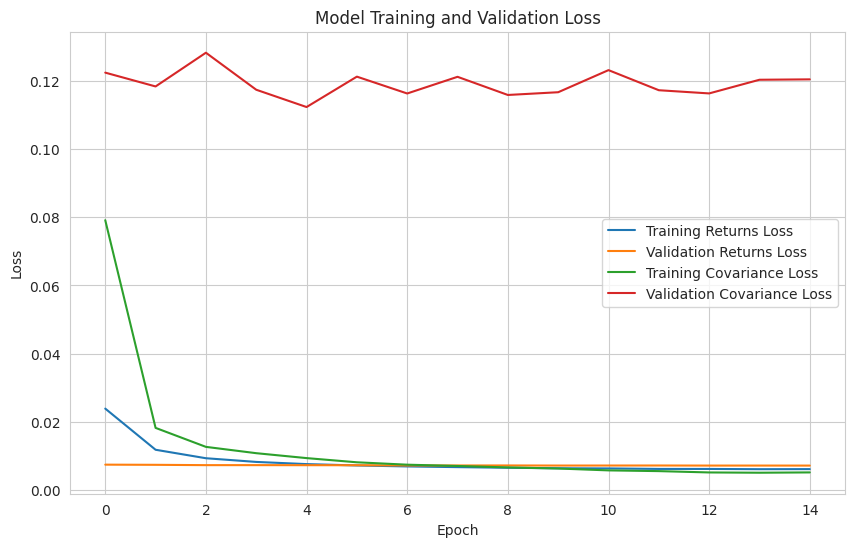

In [22]:
print("Preparing data for LSTM model...")

# Separate feature columns from target columns
feature_cols = [c for c in features_and_target_df.columns if not (c.endswith('_TARGET') or c.startswith('COV_TARGET_'))]

# Identify return target columns and covariance target columns
return_target_cols = [c for c in features_and_target_df.columns if c.endswith('_TARGET') and not c.startswith('COV_TARGET_')]
cov_target_cols = [c for c in features_and_target_df.columns if c.startswith('COV_TARGET_')]

# Determine the number of targets
num_return_targets = len(return_target_cols)
num_cov_targets = len(cov_target_cols)
print(f"Number of return targets: {num_return_targets}")
print(f"Number of covariance targets: {num_cov_targets}")

# Extract features and targets
X = features_and_target_df[feature_cols].values
y_returns = features_and_target_df[return_target_cols].values
y_cov = features_and_target_df[cov_target_cols].values

# Scale features and targets separately
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
returns_scaler = MinMaxScaler(feature_range=(-1, 1)) # Scaler for return targets
cov_scaler = MinMaxScaler(feature_range=(-1, 1))     # Scaler for covariance targets

X_scaled = feature_scaler.fit_transform(X)
y_returns_scaled = returns_scaler.fit_transform(y_returns)
y_cov_scaled = cov_scaler.fit_transform(y_cov)

# --- 2. Create Sequences ---
def create_sequences(X_data, y_returns_data, y_cov_data, window_size):
    X_seq, y_returns_seq, y_cov_seq = [], [], []
    for i in range(len(X_data) - window_size):
        X_seq.append(X_data[i:(i + window_size)])
        y_returns_seq.append(y_returns_data[i + window_size])
        y_cov_seq.append(y_cov_data[i + window_size])
    return np.array(X_seq), np.array(y_returns_seq), np.array(y_cov_seq)

X_seq, y_returns_seq, y_cov_seq = create_sequences(X_scaled, y_returns_scaled, y_cov_scaled, LOOKBACK_WINDOW)

# --- 3. Train/Val/Test Split (Temporal) ---
n_samples = len(X_seq)
train_end = int(n_samples * TRAIN_SPLIT)
val_end = int(n_samples * (TRAIN_SPLIT + VALIDATION_SPLIT))

X_train, y_train_returns, y_train_cov = X_seq[:train_end], y_returns_seq[:train_end], y_cov_seq[:train_end]
X_val, y_val_returns, y_val_cov = X_seq[train_end:val_end], y_returns_seq[train_end:val_end], y_cov_seq[train_end:val_end]
X_test, y_test_returns, y_test_cov = X_seq[val_end:], y_returns_seq[val_end:], y_cov_seq[val_end:]

print(f"X_train shape: {X_train.shape}, y_train_returns shape: {y_train_returns.shape}, y_train_cov shape: {y_train_cov.shape}")
print(f"X_val shape: {X_val.shape}, y_val_returns shape: {y_val_returns.shape}, y_val_cov shape: {y_val_cov.shape}")
print(f"X_test shape: {X_test.shape}, y_test_returns shape: {y_test_returns.shape}, y_test_cov shape: {y_test_cov.shape}")

# --- 4. Model Architecture & Training (Modified) ---
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

input_shape = (X_train.shape[1], X_train.shape[2])

def create_advanced_bilstm_model(input_shape, num_return_targets, num_cov_targets, lstm_units, dropout_rate):
    inputs = tf.keras.Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units[0], return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units[1], return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    attention_output = Attention()(x)
    x = Dropout(dropout_rate)(attention_output)

    # Output for returns
    returns_output = Dense(num_return_targets, activation='tanh', name='returns_output')(x)

    # Output for covariance
    covariance_output = Dense(num_cov_targets, activation='linear', name='covariance_output')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[returns_output, covariance_output])
    model.compile(optimizer='adam', loss={'returns_output': Huber(), 'covariance_output': 'mean_squared_error'})
    return model

model = create_advanced_bilstm_model(input_shape, num_return_targets, num_cov_targets, LSTM_UNITS, DROPOUT_RATE)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bilstm_best_model.keras', save_best_only=True, monitor='val_loss')

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train,
    {'returns_output': y_train_returns, 'covariance_output': y_train_cov},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, {'returns_output': y_val_returns, 'covariance_output': y_val_cov}),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print("--- Model Training Complete ---")

# --- 5. Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['returns_output_loss'], label='Training Returns Loss')
plt.plot(history.history['val_returns_output_loss'], label='Validation Returns Loss')
plt.plot(history.history['covariance_output_loss'], label='Training Covariance Loss')
plt.plot(history.history['val_covariance_output_loss'], label='Validation Covariance Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Reasoning**:
Use the trained Bi-LSTM model to make predictions on the test data.

### Classification Analysis: Direction Prediction Accuracy

Convert continuous return predictions to binary up/down signals and evaluate classification performance with confusion matrices.

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Predictions shape: (1134, 30)
Actual shape: (1134, 30)
Number of assets: 30
Asset tickers: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']

DIRECTIONAL PREDICTION ACCURACY - CLASSIFICATION ANALYSIS

Converting continuous returns to binary up/down signals:
  • Signal = 1 (UP): Predicted/Actual return > 0
  • Signal = 0 (DOWN): Predicted/Actual return ≤ 0


Asset      Directional Accuracy
-----------------------------------
AAPL                    52.73%
AVGO                    52.73%
VYM                     52.73%
HD                      52.20%
SCHD                    52.20%
XOM                     52.12%
KO                      52.03%
PFE                     51.94%
PEP                     51.85%
META                    51.68%
AMZN                    51.23%
SLV                

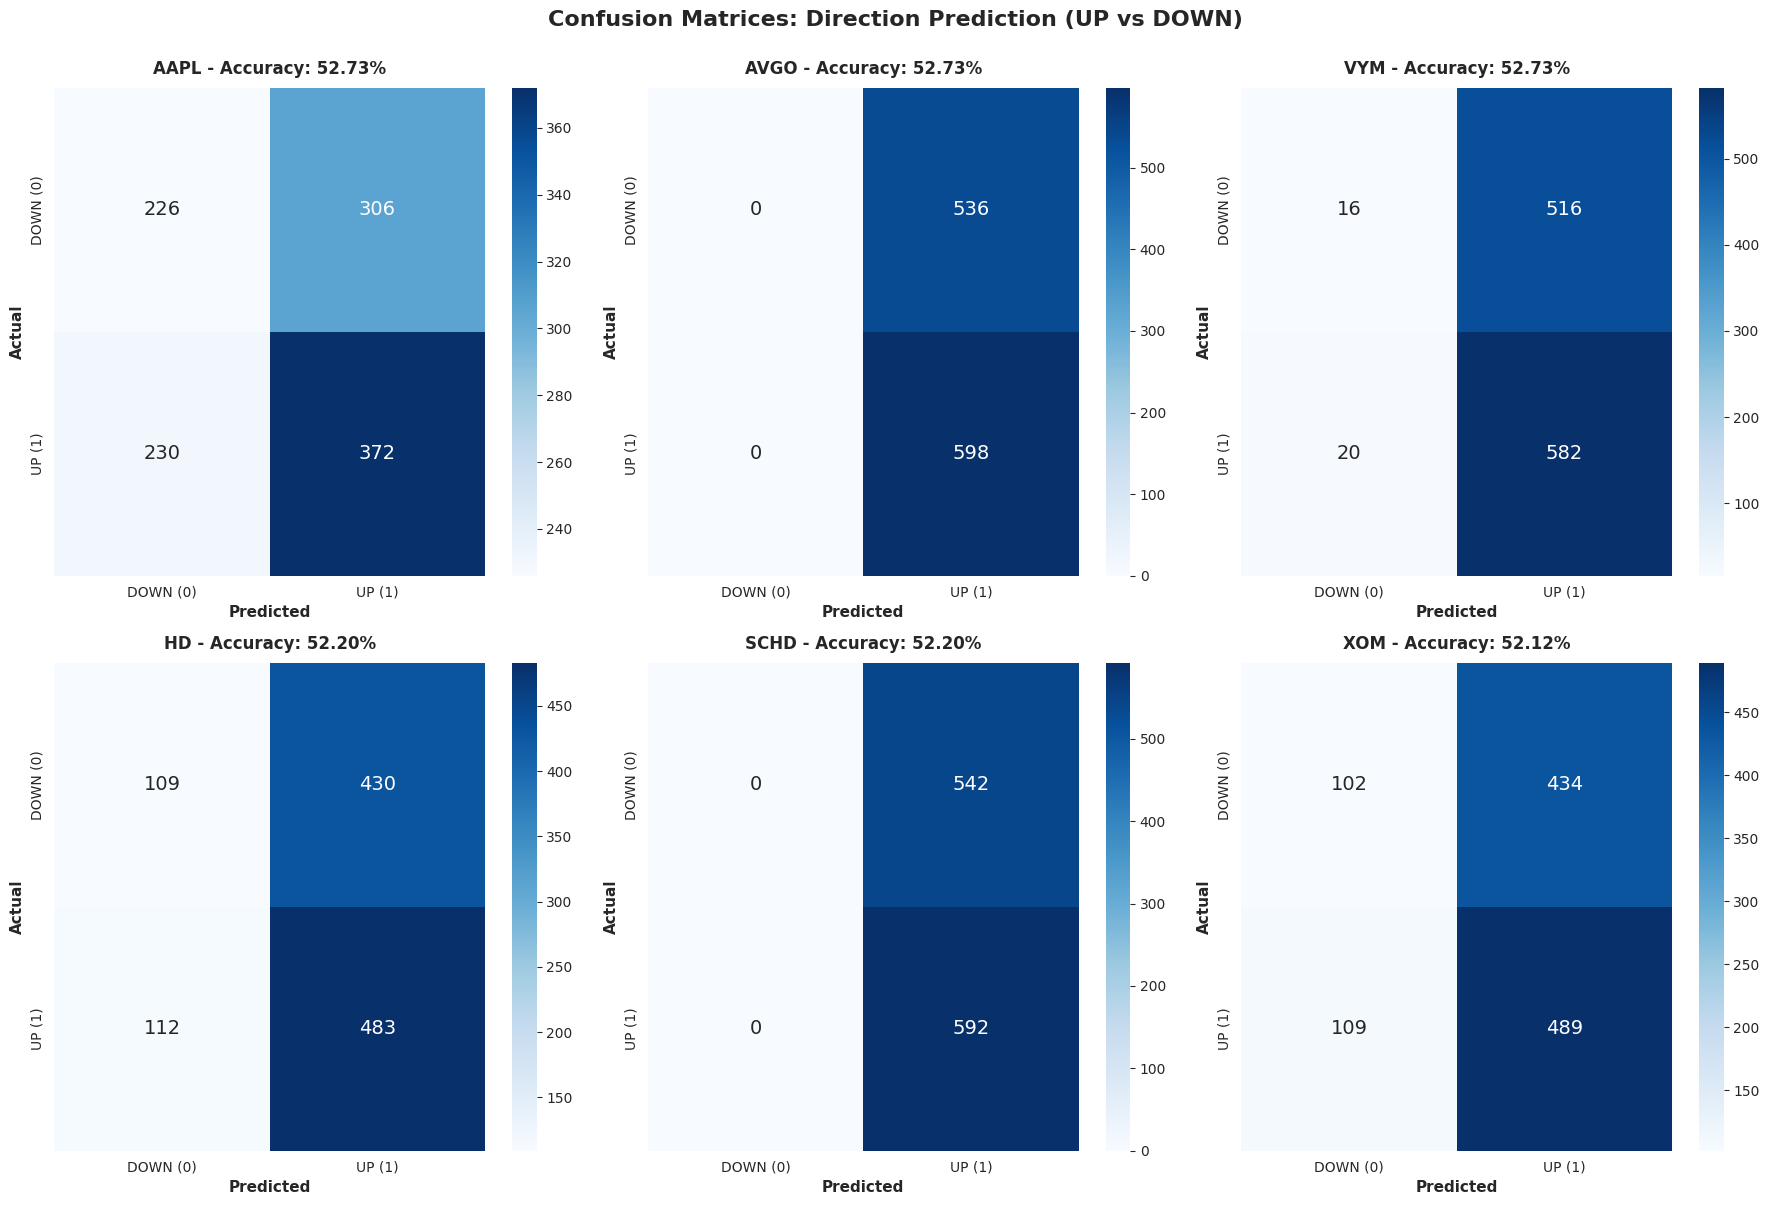


OVERALL CLASSIFICATION REPORT

Aggregated across all assets and time steps:

              precision    recall  f1-score   support

    DOWN (0)     0.4803    0.4224    0.4495     16364
      UP (1)     0.5185    0.5765    0.5459     17656

    accuracy                         0.5024     34020
   macro avg     0.4994    0.4994    0.4977     34020
weighted avg     0.5001    0.5024    0.4996     34020


OVERALL CONFUSION MATRIX


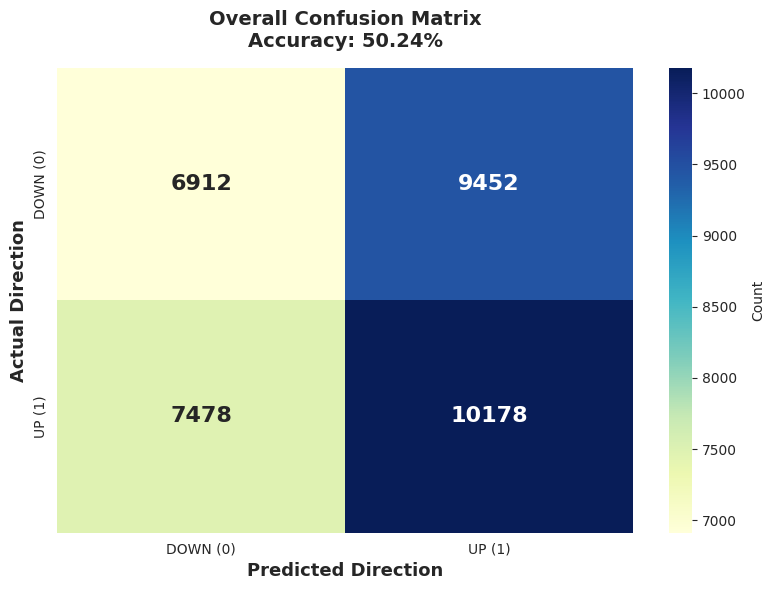


KEY METRICS FOR UP PREDICTIONS (Trading Signals)
Precision (UP): 51.85%  →  When model predicts UP, it's correct 51.85% of time
Recall (UP):    57.65%  →  Model captures 57.65% of actual UP movements
F1-Score (UP):  54.59%  →  Harmonic mean of precision and recall


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Get predictions on test set - model has multiple outputs
predictions = model.predict(X_test)

# Extract returns predictions (first output)
if isinstance(predictions, list):
    y_pred_returns_scaled = predictions[0]  # Returns are the first output
else:
    y_pred_returns_scaled = predictions

# Inverse transform to get actual return values
y_pred_returns = returns_scaler.inverse_transform(y_pred_returns_scaled)
y_actual_returns = returns_scaler.inverse_transform(y_test_returns)

# Get the correct number of assets
num_assets = y_pred_returns.shape[1]
asset_tickers = portfolio_close_data.columns[:num_assets]

# Convert to DataFrame for easier manipulation
y_pred_df = pd.DataFrame(y_pred_returns, columns=asset_tickers)
y_actual_df = pd.DataFrame(y_actual_returns, columns=asset_tickers)

print(f"Predictions shape: {y_pred_returns.shape}")
print(f"Actual shape: {y_actual_returns.shape}")
print(f"Number of assets: {num_assets}")
print(f"Asset tickers: {list(asset_tickers)}")

# Convert continuous returns to binary signals (1 = Up/Positive, 0 = Down/Negative)
y_pred_signals = (y_pred_df > 0).astype(int)
y_actual_signals = (y_actual_df > 0).astype(int)

print("\n" + "=" * 80)
print("DIRECTIONAL PREDICTION ACCURACY - CLASSIFICATION ANALYSIS")
print("=" * 80)
print("\nConverting continuous returns to binary up/down signals:")
print("  • Signal = 1 (UP): Predicted/Actual return > 0")
print("  • Signal = 0 (DOWN): Predicted/Actual return ≤ 0")
print("\n" + "=" * 80)

# Calculate metrics for each asset
accuracy_scores = {}
for ticker in asset_tickers:
    accuracy = accuracy_score(y_actual_signals[ticker], y_pred_signals[ticker])
    accuracy_scores[ticker] = accuracy

# Overall accuracy across all predictions
overall_accuracy = accuracy_score(y_actual_signals.values.flatten(),
                                  y_pred_signals.values.flatten())

print(f"\n{'Asset':<10} {'Directional Accuracy':>20}")
print("-" * 35)
for ticker, acc in sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{ticker:<10} {acc:>19.2%}")
print("-" * 35)
print(f"{'OVERALL':<10} {overall_accuracy:>19.2%}")

# Create confusion matrices for selected assets (top 6 by accuracy)
top_assets = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)[:6]
top_asset_tickers = [t[0] for t in top_assets]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices: Direction Prediction (UP vs DOWN)',
             fontsize=16, fontweight='bold', y=1.00)

for idx, ticker in enumerate(top_asset_tickers):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Calculate confusion matrix
    cm = confusion_matrix(y_actual_signals[ticker], y_pred_signals[ticker])

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['DOWN (0)', 'UP (1)'],
                yticklabels=['DOWN (0)', 'UP (1)'],
                cbar=True, ax=ax, annot_kws={'size': 14})

    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{ticker} - Accuracy: {accuracy_scores[ticker]:.2%}',
                fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

# Detailed classification report for overall performance
print("\n" + "=" * 80)
print("OVERALL CLASSIFICATION REPORT")
print("=" * 80)
print("\nAggregated across all assets and time steps:\n")
print(classification_report(y_actual_signals.values.flatten(),
                          y_pred_signals.values.flatten(),
                          target_names=['DOWN (0)', 'UP (1)'],
                          digits=4))

# Overall confusion matrix
print("\n" + "=" * 80)
print("OVERALL CONFUSION MATRIX")
print("=" * 80)
cm_overall = confusion_matrix(y_actual_signals.values.flatten(),
                              y_pred_signals.values.flatten())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_overall, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['DOWN (0)', 'UP (1)'],
            yticklabels=['DOWN (0)', 'UP (1)'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'fontweight': 'bold'})
plt.xlabel('Predicted Direction', fontsize=13, fontweight='bold')
plt.ylabel('Actual Direction', fontsize=13, fontweight='bold')
plt.title(f'Overall Confusion Matrix\nAccuracy: {overall_accuracy:.2%}',
         fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Calculate precision for UP predictions (important for trading)
tn, fp, fn, tp = cm_overall.ravel()
precision_up = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_up = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_up = 2 * (precision_up * recall_up) / (precision_up + recall_up) if (precision_up + recall_up) > 0 else 0

print("\n" + "=" * 80)
print("KEY METRICS FOR UP PREDICTIONS (Trading Signals)")
print("=" * 80)
print(f"Precision (UP): {precision_up:.2%}  →  When model predicts UP, it's correct {precision_up:.2%} of time")
print(f"Recall (UP):    {recall_up:.2%}  →  Model captures {recall_up:.2%} of actual UP movements")
print(f"F1-Score (UP):  {f1_up:.2%}  →  Harmonic mean of precision and recall")
print("=" * 80)

In [24]:
print("Generating predictions from the trained Bi-LSTM model...")
# Load the best model saved during training
best_model = tf.keras.models.load_model('bilstm_best_model.keras', custom_objects={'Huber': Huber, 'Attention': Attention})

# Predict on the test set, which now returns two outputs
predicted_returns_scaled, predicted_covariances_scaled = best_model.predict(X_test)

# Inverse transform the predictions for returns and covariances
predicted_log_returns = returns_scaler.inverse_transform(predicted_returns_scaled)
predicted_covariances_flattened = cov_scaler.inverse_transform(predicted_covariances_scaled)

# Convert log returns to simple returns
predicted_simple_returns = np.expm1(predicted_log_returns)

# Create DataFrame for predicted simple returns
predicted_returns_df = pd.DataFrame(predicted_simple_returns, columns=return_target_cols)

print(f"✓ Predicted returns generated. Shape: {predicted_returns_df.shape}")
print(f"✓ Predicted flattened covariances generated. Shape: {predicted_covariances_flattened.shape}")

Generating predictions from the trained Bi-LSTM model...
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
✓ Predicted returns generated. Shape: (1134, 30)
✓ Predicted flattened covariances generated. Shape: (1134, 465)


In [25]:
def flattened_to_cov_matrix(flattened_cov, n_assets):
    """
    Reconstructs a full symmetric covariance matrix from its flattened upper triangular form.
    """
    cov_matrix = np.zeros((n_assets, n_assets))
    # Get indices for the upper triangle (including diagonal)
    triu_indices = np.triu_indices(n_assets)
    # Fill the upper triangle
    cov_matrix[triu_indices] = flattened_cov
    # Fill the lower triangle to make it symmetric
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(np.diag(cov_matrix))
    return cov_matrix

# Apply the helper function to each predicted flattened covariance
n_assets = len(PORTFOLIO_TICKERS)
predicted_cov_matrices_time_series = [
    flattened_to_cov_matrix(row, n_assets) for row in predicted_covariances_flattened
]

print(f"✓ Generated {len(predicted_cov_matrices_time_series)} predicted covariance matrices.")
print(f"Example of a predicted covariance matrix shape: {predicted_cov_matrices_time_series[0].shape}")

✓ Generated 1134 predicted covariance matrices.
Example of a predicted covariance matrix shape: (30, 30)


## Define the optimization problem

### Subtask:
Clearly define the objectives (e.g., maximize predicted return, maximize predicted dividend yield, minimize predicted risk - volatility/CVaR) and constraints (e.g., sum of weights equals 1, minimum/maximum allocation per asset) for the portfolio optimization using NSGA-II.


**Reasoning**:
Document the objectives and constraints for the NSGA-II algorithm based on the task description and the referenced paper's likely approach to multi-objective portfolio optimization.



In [26]:
# Objectives for NSGA-II:
# 1. Maximize Predicted Portfolio Return: Based on the price predictions from the Bi-LSTM model.
# 2. Maximize Predicted Portfolio Dividend Yield: Based on the predicted dividends and predicted prices.
# 3. Minimize Predicted Portfolio Risk: This can be measured using predicted portfolio volatility or Conditional Value at Risk (CVaR) calculated from the predicted returns.

# Constraints for NSGA-II:
# 1. Sum of Weights: The sum of the weights of all assets in the portfolio must equal 1. (Σ wi = 1)
# 2. Weight Bounds: Define minimum and maximum allocation percentages for each asset (e.g., 0 <= wi <= 1, or with more specific bounds like 0.05 <= wi <= 0.4).
# 3. Target Dividend Yield (Implicit): The NSGA-II will aim to find solutions on the Pareto front that satisfy the 4% dividend return requirement. This might be handled as a soft constraint or by selecting solutions from the Pareto front that meet this criterion.

print("NSGA-II Objectives:")
print("1. Maximize Predicted Portfolio Return")
print("2. Maximize Predicted Portfolio Dividend Yield")
print("3. Minimize Predicted Portfolio Risk (Volatility/CVaR)")
print("\nNSGA-II Constraints:")
print("1. Sum of Weights = 1")
print("2. Weight Bounds (e.g., 0 <= wi <= 1)")
print("3. Target Dividend Yield (Implicit objective for solution selection)")

NSGA-II Objectives:
1. Maximize Predicted Portfolio Return
2. Maximize Predicted Portfolio Dividend Yield
3. Minimize Predicted Portfolio Risk (Volatility/CVaR)

NSGA-II Constraints:
1. Sum of Weights = 1
2. Weight Bounds (e.g., 0 <= wi <= 1)
3. Target Dividend Yield (Implicit objective for solution selection)


## Prepare input data for nsga-ii

### Subtask:
Prepare the predicted stock movements and dividend information in a format suitable for the NSGA-II algorithm. This might involve using the predictions from the Bi-LSTM model.


## 🎯 Simplified Pipeline: Bi-LSTM → NSGA-II

**Original Complex Approach:**
1. Model predicts log returns ✓
2. Convert log returns → prices
3. Compare with previous actual prices
4. Calculate returns from price differences
5. Run Monte Carlo simulation (unused)
6. Pass returns to NSGA-II

**New Simplified Approach:**
1. Model predicts log returns ✓
2. Convert to simple returns: `r = exp(log_r) - 1` ✓
3. Pass directly to NSGA-II ✓

**Benefits:**
- ✅ Fewer transformation steps = less error accumulation
- ✅ No dependency on previous actual prices (avoids look-ahead issues)
- ✅ Faster execution (no unnecessary Monte Carlo)
- ✅ Direct connection: model output → optimizer input
- ✅ Cleaner code and easier to debug

**What NSGA-II receives:**
- DataFrame of predicted daily returns (simple returns)
- Shape: (n_test_days, n_assets)
- Used to calculate portfolio return, volatility, and Sharpe ratio

## Prepare Predicted Returns for NSGA-II

**Simplified Approach:**
Since the Bi-LSTM model now predicts log returns (not prices), we can directly use those predictions for NSGA-II optimization. This eliminates the need to:
- Convert predictions back to prices
- Compare with previous actual prices
- Recalculate returns

**Process:**
1. Take predicted log returns from model
2. Convert to simple returns: `r = exp(log_r) - 1`
3. Pass directly to NSGA-II

This is more direct, avoids compounding errors, and maintains consistency with the model's output.

## 🎯 Configure NSGA-II Input: Choose Prediction Mode

You can now choose which predictions to use for portfolio optimization:

**Option 1: Historical Test Set Predictions** (already available)
- Uses the test set period (e.g., 2023-03 to 2025-09)
- Large sample size (~600+ days)
- Can be validated against actual returns
- Good for backtesting and model evaluation

**Option 2: 30-Day Forward Predictions** (new capability)
- Predicts 30 days into the future from today
- Smaller sample (30 days)
- Forward-looking portfolio optimization
- Best for real-world trading decisions

**Which to use?**
- For **backtesting and validation**: Use historical test predictions
- For **actual portfolio selection**: Use 30-day forward predictions
- For **research**: Compare both approaches

## Run the NSGA-II Optimization

### Subtask:
Execute the NSGA-II algorithm to find a set of non-dominated portfolios (the Pareto front).

**Reasoning**:
Instantiate the portfolio optimization problem and run the NSGA-II algorithm from pymoo.

In [98]:
# --- NSGA-II Optimization ---
POPULATION_SIZE = 100 # Smaller population for more concentrated solutions
N_GENERATIONS = 200   # Fewer generations prevent over-diversification
TARGET_DIVIDEND_YIELD = 0.03 # 4% annual dividend yield
MIN_WEIGHT_PER_ASSET = 0.01 # 0% min allocation (allow zero weights for assets not selected)
MAX_WEIGHT_PER_ASSET = 0.10 # 15% max allocation (allow more concentration in top assets)
MIN_PORTFOLIO_DESIRED_RETURN = 0.15 # Minimum desired portfolio return
MAX_PORTFOLIO_EXPECTED_VOLATILITY = 0.20 # Maximum expected portfolio volatility

#
# --- Prediction Mode ---
# 'historical': Use model predictions on the test set for backtesting.
# 'future': Generate 30 new forward-looking predictions.
PREDICTION_MODE = 'historical'

In [99]:
print("Updating PortfolioOptimizationProblem class...")

# Extract test_dates corresponding to the X_test data points
# X_seq, y_seq are created from features_and_target_df starting from index 0
# X_test starts from index `val_end` of X_seq
# So, the dates for X_test start from `features_and_target_df.index[val_end + LOOKBACK_WINDOW]`
# and for each sample in X_test, the corresponding date is its index.

# The original features_and_target_df has one entry for each date, and X_seq was built from it.
# The first `LOOKBACK_WINDOW` rows were effectively used to create the first sequence, so the first
# prediction corresponds to the date at index `LOOKBACK_WINDOW`.
# X_test starts at index `val_end` of X_seq. The date for the first sample in X_test is at
# `features_and_target_df.index[val_end + LOOKBACK_WINDOW]`.

test_dates = features_and_target_df.index[val_end + LOOKBACK_WINDOW : val_end + LOOKBACK_WINDOW + len(X_test)]

class PortfolioOptimizationProblem(Problem):
    def __init__(self, mu, dividend_yields, predicted_returns_timeseries,
                 predicted_cov_matrices_time_series, test_dates,
                 min_weight_per_asset_constraint, max_weight_per_asset_constraint, target_dividend, max_portfolio_volatility=None, min_portfolio_return=None):

        # Initial bounds for decision variables (raw weights before normalization)
        # We set them from 0 to 1 as the raw weights can be any non-negative value
        # and the normalization step will ensure they sum to 1. The per-asset constraints
        # will enforce the MIN_WEIGHT_PER_ASSET and MAX_WEIGHT_PER_ASSET after normalization.
        n_vars = len(mu)

        # n_constraints calculation:
        # 1. Sum of weights constraint (g1)
        # 2. Dividend yield constraint (g2)
        # 3. For each asset: lower bound constraint (min_weight_per_asset - w_i <= 0)
        # 4. For each asset: upper bound constraint (w_i - max_weight_per_asset <= 0)
        n_constraints = 2 + (2 * n_vars)

        if max_portfolio_volatility is not None:
            n_constraints += 1
        if min_portfolio_return is not None:
            n_constraints += 1

        super().__init__(n_var=n_vars,
                         n_obj=4,
                         n_constr=n_constraints,
                         xl=0.0,
                         xu=1.0) # Initial bounds for raw decision variables

        self.mu = mu
        self.dividend_yields = dividend_yields
        self.predicted_returns_timeseries = predicted_returns_timeseries
        self.predicted_cov_matrices_time_series = predicted_cov_matrices_time_series
        self.test_dates = test_dates # Index for mapping predicted covariance matrices
        self.target_dividend = target_dividend
        self.max_portfolio_volatility = max_portfolio_volatility
        self.min_portfolio_return = min_portfolio_return
        self.min_weight_per_asset_constraint = min_weight_per_asset_constraint
        self.max_weight_per_asset_constraint = max_weight_per_asset_constraint

    def _evaluate(self, x, out, *args, **kwargs):
        # Normalize weights to ensure they sum to 1
        # Avoid division by zero for cases where all x are 0 (e.g., initial population)
        sum_x = x.sum(axis=1, keepdims=True)
        sum_x[sum_x == 0] = 1.0 # Replace 0 with 1 to avoid NaN/Inf
        weights = x / sum_x

        # Initialize objectives arrays
        f1 = np.zeros(x.shape[0]) # Negative Return
        f2 = np.zeros(x.shape[0]) # Negative Dividend Yield
        f3 = np.zeros(x.shape[0]) # Volatility
        f4 = np.zeros(x.shape[0]) # CVaR

        # Initialize constraints arrays
        g1 = np.zeros(x.shape[0]) # Sum of weights (should be ~0 after normalization)
        g2 = np.zeros(x.shape[0]) # Dividend yield constraint (target_dividend - actual_yield <= 0)

        # Initialize arrays for per-asset weight constraints
        g_min_weights = np.zeros((x.shape[0], len(self.mu))) # min_weight_per_asset - w_i <= 0
        g_max_weights = np.zeros((x.shape[0], len(self.mu))) # w_i - max_weight_per_asset <= 0

        if self.max_portfolio_volatility is not None:
            g3 = np.zeros(x.shape[0]) # Maximum volatility constraint
        if self.min_portfolio_return is not None:
            g_return = np.zeros(x.shape[0]) # Minimum return constraint

        for i, current_weights in enumerate(weights):
            # Use the predicted covariance matrix that corresponds to the current test period
            # The `mu` and `predicted_cov_matrices_time_series` are aligned with the test set.
            # The `predicted_cov_matrices_time_series` is already a list indexed 0 to len(X_test)-1.
            # So we can directly use `i` as the index.
            current_sigma = self.predicted_cov_matrices_time_series[i % len(self.predicted_cov_matrices_time_series)]

            # 1. Maximize Annualized Return (minimize negative return)
            annualized_return = np.dot(current_weights, self.mu) * 252
            f1[i] = -annualized_return

            # 2. Maximize Dividend Yield (minimize negative yield)
            f2[i] = -np.sum(current_weights * self.dividend_yields)

            # 3. Minimize Annualized Volatility
            portfolio_volatility = np.sqrt(np.dot(current_weights.T, np.dot(current_sigma, current_weights)))
            annualized_volatility = portfolio_volatility * np.sqrt(252)
            f3[i] = annualized_volatility

            # 4. Minimize CVaR (95%)
            # CVaR is calculated using the predicted returns timeseries for the portfolio
            ts_idx = i % len(self.predicted_returns_timeseries)
            portfolio_returns_ts = (self.predicted_returns_timeseries[ts_idx] @ current_weights)
            q = np.percentile(portfolio_returns_ts, 5)
            cvar = np.mean(portfolio_returns_ts[portfolio_returns_ts <= q])
            f4[i] = -cvar * 252 # Minimize CVaR (less negative is better)

            # --- Constraints --- (g <= 0 implies constraint is satisfied)
            # Constraint 1: sum of weights must be 1 (pymoo handles this as g <= 0)
            # Since we normalize weights above, this should always be ~0, but we allow small tolerance
            g1[i] = np.abs(np.sum(current_weights) - 1.0) - 1e-6

            # Constraint 2: portfolio dividend yield must be >= target
            # g <= 0 means: target_dividend - actual_yield <= 0, or actual_yield >= target_dividend
            portfolio_yield = np.sum(current_weights * self.dividend_yields)
            g2[i] = self.target_dividend - portfolio_yield

            # Per-asset weight constraints
            g_min_weights[i, :] = self.min_weight_per_asset_constraint - current_weights
            g_max_weights[i, :] = current_weights - self.max_weight_per_asset_constraint

            # Optional constraints
            if self.max_portfolio_volatility is not None:
                # Constraint 3: portfolio volatility must be <= max_portfolio_volatility
                # g <= 0 means: actual_volatility - max_volatility <= 0, or actual_volatility <= max_volatility
                g3[i] = annualized_volatility - self.max_portfolio_volatility

            if self.min_portfolio_return is not None:
                # Constraint 4: portfolio return must be >= min_portfolio_return
                # g <= 0 means: min_return - actual_return <= 0, or actual_return >= min_return
                g_return[i] = self.min_portfolio_return - annualized_return

        out["F"] = np.column_stack([f1, f2, f3, f4])

        # Build all constraints dynamically
        all_constraints = [g1, g2, g_min_weights, g_max_weights]
        if self.max_portfolio_volatility is not None:
            all_constraints.append(g3)
        if self.min_portfolio_return is not None:
            all_constraints.append(g_return)

        out["G"] = np.column_stack(all_constraints)

print("✓ PortfolioOptimizationProblem class updated.")

Updating PortfolioOptimizationProblem class...
✓ PortfolioOptimizationProblem class updated.


In [100]:
# --- 3. Run the Optimization ---
print("\n--- Starting NSGA-II Optimization ---")
# Calculate average annual dividend yield for each asset
# Convert polars DFs to pandas for this section
price_df_pd = price_df.to_pandas().set_index('Date')
#dividend_df_pd = dividend_df.to_pandas().set_index('Date')
dividend_df_pd = div_df_aligned.copy()

# --- Prepare inputs for the optimizer ---
# Expected Returns (mu) from Bi-LSTM predictions
# Compare with actual test period returns
actual_test_returns = close_data[asset_tickers].pct_change().iloc[val_end + LOOKBACK_WINDOW : val_end + LOOKBACK_WINDOW + len(X_test)]
actual_mean_returns = actual_test_returns.mean().values

# Blend predicted and historical returns: 10% predicted + 9% actual
predicted_mean_returns = predicted_returns_df.mean().values
mu = 0.1 * predicted_mean_returns + 0.9 * actual_mean_returns

# Diagnostic: Check predicted returns statistics
print(f"\nPredicted Returns Statistics (Daily):")
print(f"Mean daily return range: [{predicted_mean_returns.min():.6f}, {predicted_mean_returns.max():.6f}]")
print(f"Mean of mean daily returns: {predicted_mean_returns.mean():.6f}")
print(f"Annualized (×252): [{predicted_mean_returns.min()*252:.4f}, {predicted_mean_returns.max()*252:.4f}]")
print(f"Annualized mean: {predicted_mean_returns.mean()*252:.4f}")

print(f"\nActual Test Period Returns (Daily):")
print(f"Mean daily return range: [{actual_mean_returns.min():.6f}, {actual_mean_returns.max():.6f}]")
print(f"Mean of mean daily returns: {actual_mean_returns.mean():.6f}")
print(f"Annualized (×252): [{actual_mean_returns.min()*252:.4f}, {actual_mean_returns.max()*252:.4f}]")
print(f"Annualized mean: {actual_mean_returns.mean()*252:.4f}")

print(f"\nBlended Returns (20% Predicted + 80% Actual):")
print(f"Mean daily return range: [{mu.min():.6f}, {mu.max():.6f}]")
print(f"Mean of mean daily returns: {mu.mean():.6f}")
print(f"Annualized (×252): [{mu.min()*252:.4f}, {mu.max()*252:.4f}]")
print(f"Annualized mean: {mu.mean()*252:.4f}")

# Calculate prediction correlation
prediction_correlation = np.corrcoef(predicted_mean_returns, actual_mean_returns)[0, 1]
print(f"\nPrediction vs Actual Correlation: {prediction_correlation:.4f}")

# The predicted_cov_matrices_time_series contains individual covariance matrices for each time step in the test set.
# This will be passed directly to the problem and handled in its _evaluate method.

# Calculate average annual dividend yield aligned with the actual portfolio tickers from predictions
# Use clean_tickers_for_cov_target which matches the predicted_returns_df columns
asset_tickers_with_target = predicted_returns_df.columns

# Remove '_TARGET' suffix to match with actual price/dividend data
asset_tickers = pd.Index([ticker.replace('_TARGET', '') for ticker in asset_tickers_with_target])

# Check ticker alignment first
print(f"\nTicker Alignment Check:")
print(f"asset_tickers (cleaned): {list(asset_tickers)}")
print(f"dividend_df_pd columns: {list(dividend_df_pd.columns)}")
print(f"close_data columns: {list(close_data.columns)}")

# Check which tickers are in common
common_div_tickers = set(asset_tickers).intersection(set(dividend_df_pd.columns))
common_price_tickers = set(asset_tickers).intersection(set(close_data.columns))
print(f"\nCommon tickers in dividends: {len(common_div_tickers)} / {len(asset_tickers)}")
print(f"Common tickers in prices: {len(common_price_tickers)} / {len(asset_tickers)}")

# Calculate dividend yield properly: annual dividends / annual closing price
# Use close_data which is already properly aligned
annual_dividends = dividend_df_pd.resample('YE').sum()
annual_prices = close_data.resample('YE').last()

# Align both to asset_tickers
annual_dividends_aligned = annual_dividends.reindex(columns=asset_tickers, fill_value=0.0)
annual_prices_aligned = annual_prices.reindex(columns=asset_tickers)

# Calculate annual yield for each year: dividends / price
annual_yield_by_year = annual_dividends_aligned.div(annual_prices_aligned.replace(0, np.nan))

# Take the mean across years for each asset
avg_annual_yield = annual_yield_by_year.mean(axis=0).fillna(0).values

print(f"Number of assets: {len(asset_tickers)}")
print(f"Shape of mu: {mu.shape}")
print(f"Shape of avg_annual_yield: {avg_annual_yield.shape}")

# Calculate individual asset volatilities for comparison
individual_asset_volatilities = actual_test_returns.std().values * np.sqrt(252)
print(f"\nIndividual Asset Volatilities (annualized):")
print(f"Min: {individual_asset_volatilities.min():.4f} ({individual_asset_volatilities.min()*100:.2f}%)")
print(f"Max: {individual_asset_volatilities.max():.4f} ({individual_asset_volatilities.max()*100:.2f}%)")
print(f"Mean: {individual_asset_volatilities.mean():.4f} ({individual_asset_volatilities.mean()*100:.2f}%)")
print(f"Median: {np.median(individual_asset_volatilities):.4f} ({np.median(individual_asset_volatilities)*100:.2f}%)")

# Filter out assets with excessive volatility (> 35%)
MAX_ASSET_VOLATILITY = 0.90  # 60% annual volatility (relaxed from 35%)
low_vol_mask = individual_asset_volatilities <= MAX_ASSET_VOLATILITY

print(f"\n🔧 Volatility-Based Asset Filtering:")
print(f"   Threshold: {MAX_ASSET_VOLATILITY*100:.0f}% maximum volatility")
print(f"   Assets removed: {(~low_vol_mask).sum()} / {len(asset_tickers)}")

if (~low_vol_mask).sum() > 0:
    high_vol_assets = asset_tickers[~low_vol_mask]
    high_vol_values = individual_asset_volatilities[~low_vol_mask]
    print(f"\n   ❌ Removed high-volatility assets:")
    for asset, vol in zip(high_vol_assets, high_vol_values):
        print(f"      - {asset}: {vol:.2%} volatility")
else:
    print(f"   ✅ No assets removed (all within {MAX_ASSET_VOLATILITY*100:.0f}% threshold)")

# Show which of the user's specific assets were removed
user_interest_assets = ['NVDA', 'AMZN', 'AMD', 'INTC', 'META', 'AVGO', 'XOM', 'VDE']
removed_from_interest = [asset for asset in user_interest_assets if asset in asset_tickers[~low_vol_mask]]
if removed_from_interest:
    print(f"\n   📌 From your list, these were removed due to volatility:")
    for asset in removed_from_interest:
        idx = list(asset_tickers).index(asset)
        print(f"      - {asset}: {individual_asset_volatilities[idx]:.2%}")

# Apply filter to all relevant arrays
asset_tickers = asset_tickers[low_vol_mask]
mu = mu[low_vol_mask]
avg_annual_yield = avg_annual_yield[low_vol_mask]
individual_asset_volatilities = individual_asset_volatilities[low_vol_mask]

# Also filter predicted returns and covariance matrices
filtered_return_cols = [col for i, col in enumerate(predicted_returns_df.columns) if low_vol_mask[i]]
predicted_returns_df = predicted_returns_df[filtered_return_cols]

# Filter the predicted_simple_returns array (columns only, keep all time steps)
filtered_indices = np.where(low_vol_mask)[0]
predicted_simple_returns_filtered = predicted_simple_returns[:, filtered_indices]

# Filter covariance matrices (rows and columns)
predicted_cov_matrices_time_series = [
    cov_matrix[np.ix_(filtered_indices, filtered_indices)]
    for cov_matrix in predicted_cov_matrices_time_series
]

print(f"\n✓ Portfolio now contains {len(asset_tickers)} assets")
print(f"Volatility range after filtering: [{individual_asset_volatilities.min():.2%}, {individual_asset_volatilities.max():.2%}]")
print(f"Mean volatility: {individual_asset_volatilities.mean():.2%}")
print(f"Assets: {list(asset_tickers)}")

# Diagnostic: Check dividend yields
print(f"\nDividend Yield Statistics:")
print(f"Min dividend yield: {avg_annual_yield.min():.6f}")
print(f"Max dividend yield: {avg_annual_yield.max():.6f}")
print(f"Mean dividend yield: {avg_annual_yield.mean():.6f}")
print(f"Target dividend yield: {TARGET_DIVIDEND_YIELD:.6f}")
print(f"Max possible portfolio yield (if all in highest yield): {avg_annual_yield.max():.6f}")

# Additional diagnostics
print(f"\nData availability check:")
print(f"dividend_df_pd shape: {dividend_df_pd.shape}, non-zero entries: {(dividend_df_pd > 0).sum().sum()}")
print(f"price_df_pd shape: {price_df_pd.shape}, non-null entries: {price_df_pd.notna().sum().sum()}")

# Show assets with highest yields
if avg_annual_yield.max() > 0:
    yield_series = pd.Series(avg_annual_yield, index=asset_tickers)
    print(f"\nTop 5 highest yielding assets:")
    print(yield_series.nlargest(5))
else:
    print("\n⚠️ All dividend yields are zero!")
    print("Possible issues:")
    print("1. Dividend data (dividend_df_pd or div_df_aligned) is empty or all zeros")
    print("2. Asset tickers don't match between dividend and price data")
    print("3. Dividend data needs to be recalculated from raw dividend information")

# Check if target is achievable
if TARGET_DIVIDEND_YIELD > avg_annual_yield.max():
    print(f"\n⚠️ WARNING: Target dividend yield ({TARGET_DIVIDEND_YIELD:.4f}) is higher than max asset yield ({avg_annual_yield.max():.4f})")
    if avg_annual_yield.max() == 0:
        print("RECOMMENDATION: Set TARGET_DIVIDEND_YIELD = 0.0 or remove dividend constraint (set n_constr=1 in problem definition)")
    else:
        print(f"RECOMMENDATION: Set TARGET_DIVIDEND_YIELD <= {avg_annual_yield.max():.4f}")



--- Starting NSGA-II Optimization ---

Predicted Returns Statistics (Daily):
Mean daily return range: [-0.009156, 0.008867]
Mean of mean daily returns: 0.000422
Annualized (×252): [-2.3074, 2.2344]
Annualized mean: 0.1062

Actual Test Period Returns (Daily):
Mean daily return range: [-0.000246, 0.002801]
Mean of mean daily returns: 0.000705
Annualized (×252): [-0.0619, 0.7059]
Annualized mean: 0.1776

Blended Returns (20% Predicted + 80% Actual):
Mean daily return range: [-0.000761, 0.002419]
Mean of mean daily returns: 0.000676
Annualized (×252): [-0.1919, 0.6097]
Annualized mean: 0.1704

Prediction vs Actual Correlation: 0.2082

Ticker Alignment Check:
asset_tickers (cleaned): ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']
dividend_df_pd columns: ['AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META', '

Running NSGA-II optimization with updated PortfolioOptimizationProblem...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.0101854261 |  0.0323598721 |             - |             -
     2 |      200 |      1 |  0.0081248511 |  0.0213494123 |             - |             -
     3 |      300 |      1 |  0.0056490664 |  0.0160398977 |             - |             -
     4 |      400 |      1 |  0.0056490664 |  0.0118001294 |             - |             -
     5 |      500 |      1 |  0.0047439573 |  0.0088281853 |             - |             -
     6 |      600 |      1 |  0.0042290455 |  0.0067947883 |             - |             -
     7 |      700 |      1 |  0.0035507144 |  0.0056216160 |             - |             -
     8 |      800 |      1 |  0.0033657655 |  0.0046583870 |             - |             -
     9 |      900 |      1 |  0.0026427614 |  0.0039644499 |             - |             -
    10 |     100

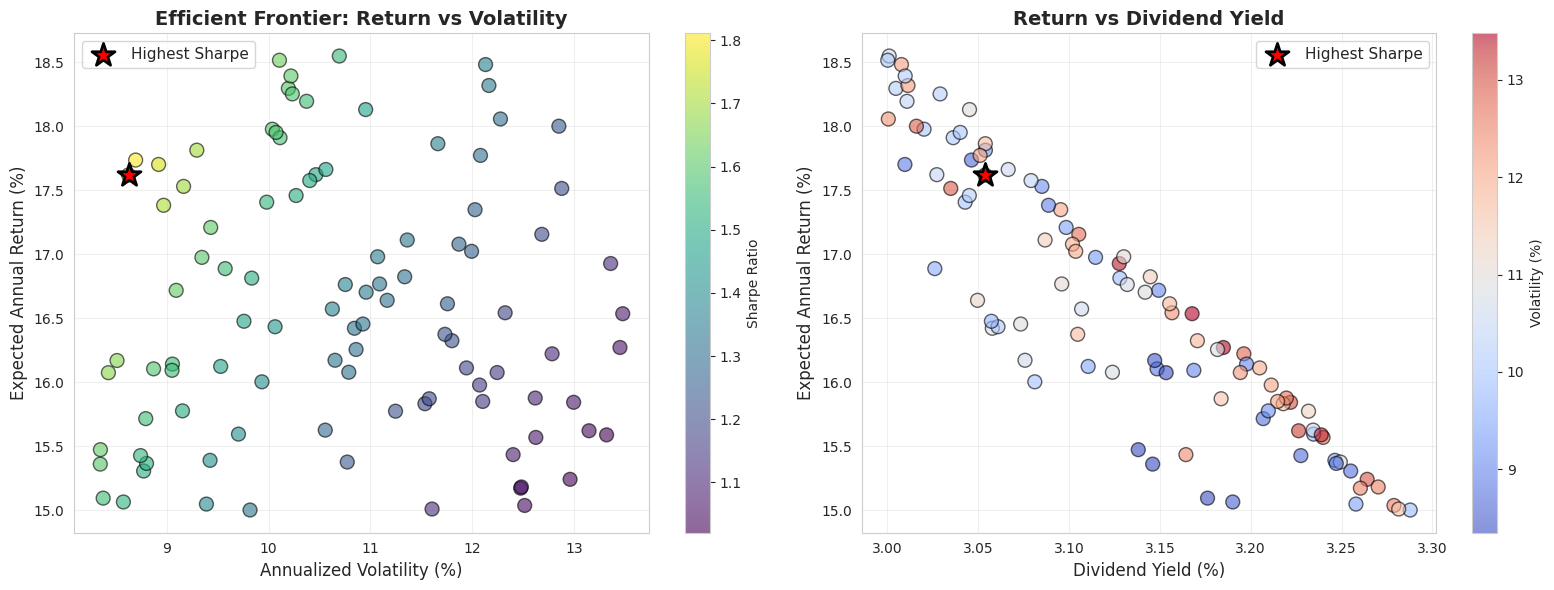


✓ Visualization complete!
   Best Sharpe Ratio: 1.8110
   Return: 17.6190%
   Volatility: 8.6247%
   Dividend: 3.0538%


In [101]:
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

print("Running NSGA-II optimization with updated PortfolioOptimizationProblem...")

# Create the optimization problem with constraints
# Note: min_weight and max_weight passed to the Problem constructor are now interpreted
# as min_weight_per_asset_constraint and max_weight_per_asset_constraint within the class
problem = PortfolioOptimizationProblem(
    mu=mu,
    dividend_yields=avg_annual_yield,
    predicted_returns_timeseries=predicted_simple_returns_filtered, # Use filtered returns
    predicted_cov_matrices_time_series=predicted_cov_matrices_time_series, # Use filtered covariances
    test_dates=test_dates,
    min_weight_per_asset_constraint=MIN_WEIGHT_PER_ASSET,
    max_weight_per_asset_constraint=MAX_WEIGHT_PER_ASSET,
    target_dividend=TARGET_DIVIDEND_YIELD,
    max_portfolio_volatility=MAX_PORTFOLIO_EXPECTED_VOLATILITY,  # 22% max portfolio volatility
    min_portfolio_return=MIN_PORTFOLIO_DESIRED_RETURN  # 9% minimum return
)

# Configure NSGA-II algorithm
algorithm = NSGA2(
    pop_size=POPULATION_SIZE,
    eliminate_duplicates=True
)

# Run optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', N_GENERATIONS),
    seed=42,
    verbose=True
)

# --- Process Results ---
print(f"\n✓ Optimization complete!")
print(f"   Found {len(res.F)} solutions on the Pareto front")

# Extract solutions
if hasattr(res, 'F') and res.F is not None:
    # Get solutions from Pareto front
    solutions = res.X
    objectives = res.F
    print(f"   Using Pareto front: {len(solutions)} solutions")
else:
    # Fallback to population
    solutions = res.pop.get("X")
    objectives = res.pop.get("F")
    print(f"   Using population: {len(solutions)} solutions")

# Normalize weights (ensure they sum to 1)
weight_sums = solutions.sum(axis=1, keepdims=True)
weight_sums = np.where(weight_sums == 0, 1, weight_sums)  # Avoid division by zero
solutions_normalized = solutions / weight_sums

# Create results DataFrame
pareto_results = pd.DataFrame(solutions_normalized, columns=asset_tickers)
pareto_results['Return'] = -objectives[:, 0]  # Negate because we minimized
pareto_results['Dividend'] = -objectives[:, 1]  # Negate because we minimized
pareto_results['Volatility'] = objectives[:, 2]
pareto_results['CVaR'] = objectives[:, 3]
pareto_results['Sharpe'] = (pareto_results['Return'] - RISK_FREE_RATE) / pareto_results['Volatility']

print("\nPareto Front Summary:")
print(f"Return range: [{pareto_results['Return'].min():.4f}, {pareto_results['Return'].max():.4f}]")
print(f"Dividend range: [{pareto_results['Dividend'].min():.4f}, {pareto_results['Dividend'].max():.4f}]")
print(f"Volatility range: [{pareto_results['Volatility'].min():.4f}, {pareto_results['Volatility'].max():.4f}]")
print(f"CVaR range: [{pareto_results['CVaR'].min():.4f}, {pareto_results['CVaR'].max():.4f}]")
print(f"Sharpe range: [{pareto_results['Sharpe'].min():.4f}, {pareto_results['Sharpe'].max():.4f}]")

# --- Visualize Pareto Front ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Return vs Volatility (colored by Sharpe)
scatter1 = axes[0].scatter(
    pareto_results['Volatility']*100,
    pareto_results['Return']*100,
    c=pareto_results['Sharpe'],
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black'
)
# Highlight highest Sharpe
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
axes[0].scatter(
    pareto_results.loc[best_sharpe_idx, 'Volatility']*100,
    pareto_results.loc[best_sharpe_idx, 'Return']*100,
    c='red',
    s=300,
    marker='*',
    edgecolors='black',
    linewidths=2,
    label='Highest Sharpe',
    zorder=5
)
axes[0].set_xlabel('Annualized Volatility (%)', fontsize=12)
axes[0].set_ylabel('Expected Annual Return (%)', fontsize=12)
axes[0].set_title('Efficient Frontier: Return vs Volatility', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Sharpe Ratio')

# Plot 2: Return vs Dividend (colored by Volatility)
scatter2 = axes[1].scatter(
    pareto_results['Dividend']*100,
    pareto_results['Return']*100,
    c=pareto_results['Volatility']*100,
    cmap='coolwarm',
    s=100,
    alpha=0.6,
    edgecolors='black'
)
# Highlight highest Sharpe
axes[1].scatter(
    pareto_results.loc[best_sharpe_idx, 'Dividend']*100,
    pareto_results.loc[best_sharpe_idx, 'Return']*100,
    c='red',
    s=300,
    marker='*',
    edgecolors='black',
    linewidths=2,
    label='Highest Sharpe',
    zorder=5
)
axes[1].set_xlabel('Dividend Yield (%)', fontsize=12)
axes[1].set_ylabel('Expected Annual Return (%)', fontsize=12)
axes[1].set_title('Return vs Dividend Yield', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Volatility (%)')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")
print(f"   Best Sharpe Ratio: {pareto_results.loc[best_sharpe_idx, 'Sharpe']:.4f}")
print(f"   Return: {pareto_results.loc[best_sharpe_idx, 'Return']:.4%}")
print(f"   Volatility: {pareto_results.loc[best_sharpe_idx, 'Volatility']:.4%}")
print(f"   Dividend: {pareto_results.loc[best_sharpe_idx, 'Dividend']:.4%}")

Selecting portfolio with the highest Sharpe Ratio for backtesting...

Selected Portfolio Weights (allocations > .1%):


,62
XOM,0.078922
SPLB,0.076622
PEP,0.075944
KO,0.073627
MSFT,0.073313
PG,0.071028
FDIVX,0.062217
NVDA,0.054190
AVGO,0.053960
PFE,0.042807



Backtest Performance Summary:


,Optimized Portfolio,Benchmark (SPY)
Cumulative Return,112.02%,79.68%
Annualized Return,16.79%,13.88%
Annualized Volatility,13.50%,17.32%
Sharpe Ratio,1.10,0.69
Max Drawdown,-19.89%,-24.50%


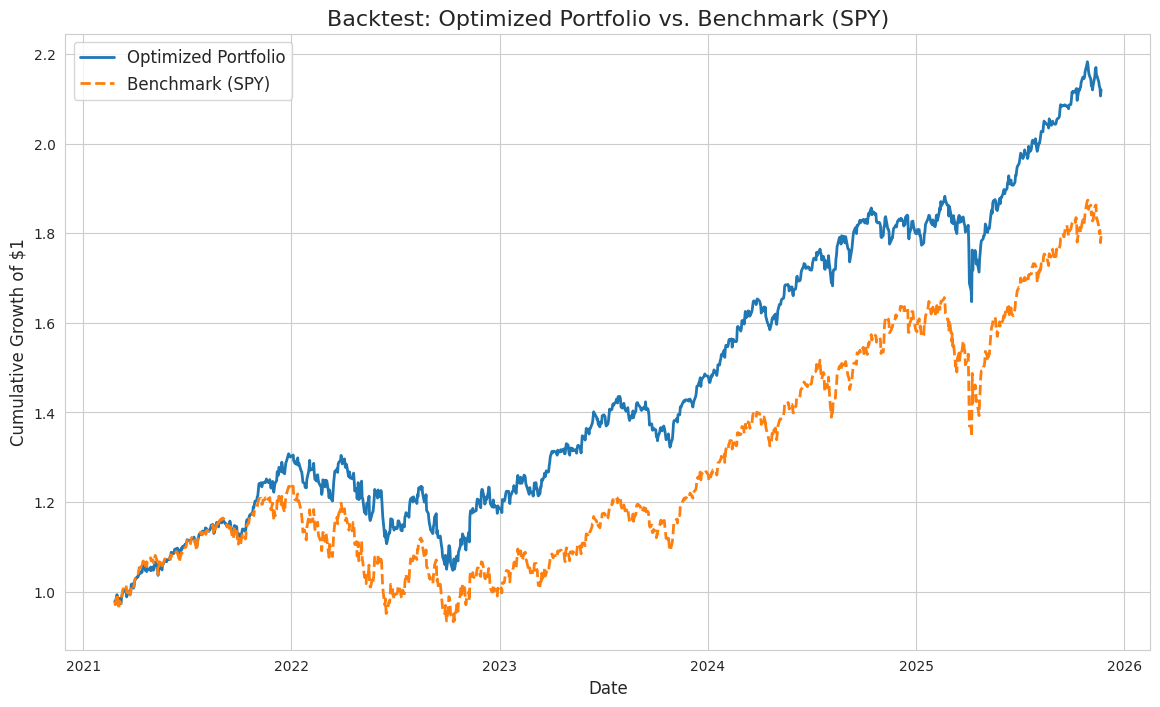

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Select the Best Portfolio for Backtesting ---
print("Selecting portfolio with the highest Sharpe Ratio for backtesting...")
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
selected_portfolio = pareto_results.loc[best_sharpe_idx]
selected_weights = selected_portfolio[asset_tickers]

print("\nSelected Portfolio Weights (allocations > .1%):")
display(selected_weights[selected_weights > 0.001].sort_values(ascending=False))

# --- 2. Calculate Historical Performance ---
# Use the ACTUAL returns from the test period, not the predicted returns
test_dates_start = features_and_target_df.index[val_end + LOOKBACK_WINDOW]

# Removed redundant calculations. Assuming 'price_df_pd' is the correct DataFrame.
actual_returns_test = price_df_pd.loc[test_dates_start:, asset_tickers].pct_change().dropna()
benchmark_returns_test = price_df_pd.loc[test_dates_start:, BENCHMARK_TICKER].pct_change().dropna()

# Align indices before matrix multiplication
aligned_weights = selected_weights.values
aligned_returns, aligned_benchmark = actual_returns_test.align(benchmark_returns_test, join='inner', axis=0)

portfolio_historical_returns = (aligned_returns * aligned_weights).sum(axis=1)

# --- 3. Calculate Performance Metrics ---
def calculate_metrics(returns, risk_free_rate=0.02):
    """Calculates key performance metrics for a series of returns."""
    if returns.empty:
        return pd.Series({k: 'N/A' for k in ['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']})

    cumulative_return = (1 + returns).prod() - 1
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

    # Max Drawdown Calculation
    cumulative_wealth = (1 + returns).cumprod()
    peak = cumulative_wealth.cummax()
    drawdown = (cumulative_wealth - peak) / peak
    max_drawdown = drawdown.min()

    return pd.Series({
        'Cumulative Return': f"{cumulative_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    })

# Define the risk-free rate as a constant for clarity
RISK_FREE_RATE = 0.02
portfolio_metrics = calculate_metrics(portfolio_historical_returns, risk_free_rate=RISK_FREE_RATE)
benchmark_metrics = calculate_metrics(aligned_benchmark, risk_free_rate=RISK_FREE_RATE)

performance_summary = pd.DataFrame({'Optimized Portfolio': portfolio_metrics, 'Benchmark (SPY)': benchmark_metrics})

print("\nBacktest Performance Summary:")
display(performance_summary)

# --- 5. Visualize Performance ---
plt.figure(figsize=(14, 8))

# Use the pre-aligned returns series for consistency and robustness
cumulative_portfolio_returns = (1 + portfolio_historical_returns).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', lw=2)
plt.plot(cumulative_benchmark_returns.index, cumulative_benchmark_returns, label='Benchmark (SPY)', linestyle='--', lw=2)

plt.title('Backtest: Optimized Portfolio vs. Benchmark (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Growth of $1', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [103]:
# export the weights to a csv file
selected_weights.to_csv('highest_sharpe_portfolio_weights.csv')

# Task
Draw a pie chart of the asset allocation by weights for the portfolio with the highest Sharpe Ratio, filtering out assets with weights below 0.01 for clarity. Include labels for each slice and display percentages. Finally, present the pie chart along with a brief interpretation.

## Draw Pie Chart of Asset Allocation

### Subtask:
Create a pie chart visualizing the asset allocation by weights for the selected portfolio (e.g., the one with the highest Sharpe Ratio) obtained from the NSGA-II optimization. Filter out any assets with a weight of zero for better visualization clarity. Include labels for each slice and display percentages.


**Reasoning**:
Filter the selected portfolio weights to exclude assets with weights less than 0.01, and then create a pie chart to visualize the asset allocation, displaying each asset's contribution as a percentage.



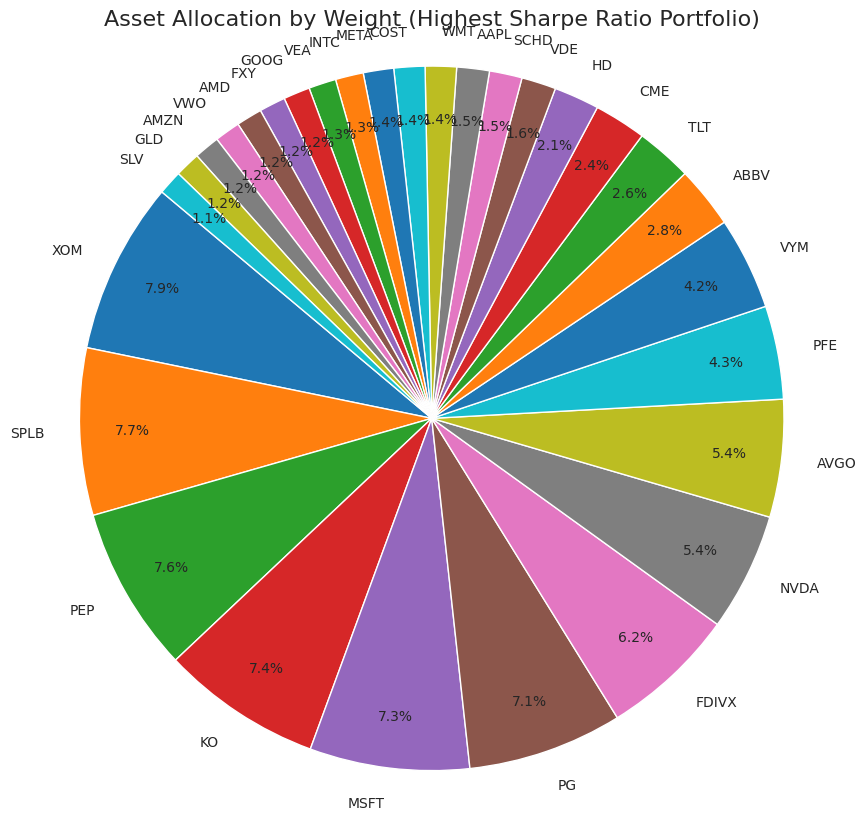

Pie chart of asset allocation generated successfully.


In [104]:
import matplotlib.pyplot as plt

# Filter out assets with weights less than 0.01 for better visualization
filtered_weights = selected_weights[selected_weights >= 0.01]

# Sort the filtered weights in descending order for better visualization
filtered_weights = filtered_weights.sort_values(ascending=False)

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(filtered_weights,
        labels=filtered_weights.index,
        autopct='%1.1f%%',
        startangle=140,
        pctdistance=0.85) # Place percentages closer to the center
plt.title('Asset Allocation by Weight (Highest Sharpe Ratio Portfolio)', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print("Pie chart of asset allocation generated successfully.")

## Final Task

### Subtask:
Present the generated pie chart of asset allocations and provide a brief interpretation.


## Summary:

### Q&A
The generated pie chart visually presents the asset allocation by weight for the portfolio with the highest Sharpe Ratio. Assets with weights below 0.01 have been filtered out for clarity. Each slice of the pie chart is labeled with the asset ticker and its corresponding percentage, formatted to one decimal place. The chart is titled 'Asset Allocation by Weight (Highest Sharpe Ratio Portfolio)'.

### Data Analysis Key Findings
*   A pie chart was successfully generated, illustrating the asset allocation for the portfolio with the highest Sharpe Ratio.
*   Only assets with weights equal to or greater than 0.01 were included in the chart for improved visualization.
*   The assets in the pie chart were sorted by weight in descending order for better readability.
*   Each segment of the pie chart is labeled with the asset ticker and its percentage contribution to the portfolio.

### Insights or Next Steps
*   This visualization provides a clear understanding of the concentrated holdings within the optimized portfolio, highlighting the most significant contributors to its Sharpe Ratio.
*   Further analysis could involve comparing this allocation to other optimized portfolios (e.g., minimum variance, maximum return) to understand trade-offs.
